# Imports and installations

In [ ]:
!pip install catboost
!pip install shap
!pip install flaml
!pip install optuna
!pip install mlxtend
!pip install kaleido
!pip uninstall plotly
!pip install plotly==5.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
Found existing installation: plotly 5.15.0
Uninstalling plotly-5.15.0:
  Would remove:
    /usr/local/etc/jupyter/nbconfig/notebook.d/jupyterlab-plotly.json
    /usr/local/lib/python3.10/dist-packages/_plotly_future_/*
    /usr/local/lib/python3.10/dist-packages/_plotly_utils/*
    /usr/local/lib/python3.10/dist-packages/jupyterlab_plotly/*
    /usr/local/lib/python3.10/dist-packages/plotly-5.15.0.dist-info/*
    /usr/local/lib

In [ ]:
# Standard library imports
import ast
import six
import sys

In [ ]:
# Third-party imports
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kaleido
import plotly.express as px
import shap
import optuna
from optuna.samplers import TPESampler
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,
                              RandomForestRegressor, StackingClassifier)
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFECV
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  LogisticRegressionCV, SGDClassifier)
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, roc_auc_score, r2_score,
                             matthews_corrcoef, average_precision_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split, StratifiedKFold)
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder,
                                   RobustScaler, StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from flaml import AutoML
import lightgbm as lgb
from mlxtend.feature_selection import (SequentialFeatureSelector as SFS)
from mlxtend.plotting import (plot_sequential_feature_selection as plot_sfs)

# Fixing joblib import issue
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set pandas display options
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)

In [ ]:
pd.set_option('display.precision', 3)

In [ ]:
random_state=1

In [ ]:
joblib.__version__

'1.4.2'

In [ ]:
from shap.utils import format_value
from shap.plots import colors
from shap.plots._labels import labels
import matplotlib
def waterfall(shap_values, max_display=10, show=True, save=False,path=''):
    # Turn off interactive plot
    if show is False:
        plt.ioff()

    # make sure the input is an Explanation object
    if not isinstance(shap_values, shap.Explanation):
        emsg = (
            "The waterfall plot requires an `Explanation` object as the "
            "`shap_values` argument."
        )
        raise TypeError(emsg)

    # make sure we only have a single explanation to plot
    sv_shape = shap_values.shape
    if len(sv_shape) != 1:
        emsg = (
            "The waterfall plot can currently only plot a single explanation, but a "
            f"matrix of explanations (shape {sv_shape}) was passed! Perhaps try "
            "`shap.plots.waterfall(shap_values[0])` or for multi-output models, "
            "try `shap.plots.waterfall(shap_values[0, 0])`."
        )
        raise ValueError(emsg)

    base_values = float(shap_values.base_values)
    features = shap_values.display_data if shap_values.display_data is not None else shap_values.data
    feature_names = shap_values.feature_names
    lower_bounds = getattr(shap_values, "lower_bounds", None)
    upper_bounds = getattr(shap_values, "upper_bounds", None)
    values = shap_values.values
    #values = []

    # unwrap pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # fallback feature names
    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(values))])

    # init variables we use for tracking the plot locations
    num_features = min(max_display, len(values))
    row_height = 0.5
    rng = range(num_features - 1, -1, -1)
    order = np.argsort(-np.abs(values))
    pos_lefts = []
    pos_inds = []
    pos_widths = []
    pos_low = []
    pos_high = []
    neg_lefts = []
    neg_inds = []
    neg_widths = []
    neg_low = []
    neg_high = []
    loc = base_values + values.sum()
    yticklabels = ["" for _ in range(num_features + 1)]

    # size the plot based on how many features we are plotting
    plt.gcf().set_size_inches(8, num_features * row_height + 1.5)

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features == len(values):
        num_individual = num_features
    else:
        num_individual = num_features - 1

    # compute the locations of the individual features and plot the dashed connecting lines
    for i in range(num_individual):
        sval = values[order[i]]
        loc -= sval
        if sval >= 0:
            pos_inds.append(rng[i])
            pos_widths.append(sval)
            if lower_bounds is not None:
                pos_low.append(lower_bounds[order[i]])
                pos_high.append(upper_bounds[order[i]])
            pos_lefts.append(loc)
        else:
            neg_inds.append(rng[i])
            neg_widths.append(sval)
            if lower_bounds is not None:
                neg_low.append(lower_bounds[order[i]])
                neg_high.append(upper_bounds[order[i]])
            neg_lefts.append(loc)
        if num_individual != num_features or i + 4 < num_individual:
            plt.plot([loc, loc], [rng[i] - 1 - 0.4, rng[i] + 0.4],
                     color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
        if features is None:
            yticklabels[rng[i]] = feature_names[order[i]]
        else:
            if np.issubdtype(type(features[order[i]]), np.number):
                yticklabels[rng[i]] = shap.utils.format_value(float(features[order[i]]), "%0.02f") + " = " + feature_names[order[i]]
            else:
                yticklabels[rng[i]] = str(features[order[i]]) + " = " + str(feature_names[order[i]])

    # add a last grouped feature to represent the impact of all the features we didn't show
    if num_features < len(values):
        yticklabels[0] = "%d other features" % (len(values) - num_features + 1)
        remaining_impact = base_values - loc
        if remaining_impact < 0:
            pos_inds.append(0)
            pos_widths.append(-remaining_impact)
            pos_lefts.append(loc + remaining_impact)
        else:
            neg_inds.append(0)
            neg_widths.append(-remaining_impact)
            neg_lefts.append(loc + remaining_impact)

    points = pos_lefts + list(np.array(pos_lefts) + np.array(pos_widths)) + neg_lefts + \
        list(np.array(neg_lefts) + np.array(neg_widths))
    dataw = np.max(points) - np.min(points)

    # draw invisible bars just for sizing the axes
    label_padding = np.array([0.1*dataw if w < 1 else 0 for w in pos_widths])
    plt.barh(pos_inds, np.array(pos_widths) + label_padding + 0.02*dataw,
             left=np.array(pos_lefts) - 0.01*dataw, color=colors.red_rgb, alpha=0)
    label_padding = np.array([-0.1*dataw if -w < 1 else 0 for w in neg_widths])
    plt.barh(neg_inds, np.array(neg_widths) + label_padding - 0.02*dataw,
             left=np.array(neg_lefts) + 0.01*dataw, color=colors.blue_rgb, alpha=0)

    # define variable we need for plotting the arrows
    head_length = 0.08
    bar_width = 0.8
    xlen = plt.xlim()[1] - plt.xlim()[0]
    fig = plt.gcf()
    ax = plt.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen/width
    hl_scaled = bbox_to_xscale * head_length
    renderer = fig.canvas.get_renderer()

    # draw the positive arrows
    for i in range(len(pos_inds)):
        dist = pos_widths[i]
        arrow_color = colors.red_rgb # if round(dist,2) != 0 else "#cccccc"  # Change color to grey if value is zero
        dist = dist #if round(dist,2) != 0 else 0
        arrow_obj = plt.arrow(
            pos_lefts[i], pos_inds[i], max(dist-hl_scaled, 0.000001), 0,
            head_length=min(dist, hl_scaled),
            color=arrow_color, width=bar_width,
            head_width=bar_width,
        )

        if pos_low is not None and i < len(pos_low):
            plt.errorbar(
                pos_lefts[i] + pos_widths[i], pos_inds[i],
                xerr=np.array([[pos_widths[i] - pos_low[i]], [pos_high[i] - pos_widths[i]]]),
                ecolor=colors.light_red_rgb,
            )

        if True:#round(pos_widths[i],2) > 0:
          text_color = colors.red_rgb
          format_text_value = '%+0.03f'
        else:
          text_color = "#cccccc"
          format_text_value = '%0.02f'

        txt_obj = plt.text(
            pos_lefts[i] + 0.5*dist, pos_inds[i], format_value(pos_widths[i], format_text_value),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            if True:#round(pos_widths[i],2) > 0:
              text_color = colors.red_rgb
              format_text_value = '%+0.03f'
            else:
              text_color = "#cccccc"
              format_text_value = '%0.02f'

            txt_obj = plt.text(
              pos_lefts[i] + (5/72)*bbox_to_xscale + dist, pos_inds[i], format_value(pos_widths[i], format_text_value),
              horizontalalignment='left', verticalalignment='center', color=text_color,
              fontsize=12,
            )


    # draw the negative arrows
    for i in range(len(neg_inds)):
        dist = neg_widths[i]
        arrow_color = colors.blue_rgb# if round(dist,2) != 0 else "#cccccc"  # Change color to grey if value is zero
        dist = dist# if round(dist,2) != 0 else 0
        arrow_obj = plt.arrow(
            neg_lefts[i], neg_inds[i], -max(-dist-hl_scaled, 0.000001), 0,
            head_length=min(-dist, hl_scaled),
            color=arrow_color, width=bar_width,
            head_width=bar_width,
        )

        if neg_low is not None and i < len(neg_low):
            plt.errorbar(
                neg_lefts[i] + neg_widths[i], neg_inds[i],
                xerr=np.array([[neg_widths[i] - neg_low[i]], [neg_high[i] - neg_widths[i]]]),
                ecolor=colors.light_blue_rgb,
            )
        if True:#np.abs(round(neg_widths[i],2)) > 0:
          text_color = colors.blue_rgb
          format_text_value = '%-0.03f'
        else:
          text_color = "#cccccc"
          format_text_value = '%0.02f'

        txt_obj = plt.text(
            neg_lefts[i] + 0.5*dist, neg_inds[i], format_value(neg_widths[i], format_text_value),
            horizontalalignment='center', verticalalignment='center', color="white",
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)
        # if the text overflows the arrow then draw it after the arrow
        if text_bbox.width > arrow_bbox.width:
            txt_obj.remove()

            if True:#np.abs(round(neg_widths[i],2)) > 0:
              text_color = colors.blue_rgb
              format_text_value = '%-0.03f'
            else:
              text_color = "#cccccc"
              format_text_value = '%0.03f'

            txt_obj = plt.text(
              neg_lefts[i] - (5/72)*bbox_to_xscale + dist, neg_inds[i], format_value(neg_widths[i],format_text_value),
              horizontalalignment='right', verticalalignment='center', color=text_color,
              fontsize=12,
              )

    # draw the y-ticks twice, once in gray and then again with just the feature names in black
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ytick_pos = list(range(num_features)) + list(np.arange(num_features)+1e-8)
    plt.yticks(ytick_pos, yticklabels[:-1] + [label.split('=')[-1] for label in yticklabels[:-1]], fontsize=13)

    # put horizontal lines for each feature row
    for i in range(num_features):
        plt.axhline(i, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

    # mark the prior expected value and the model prediction
    plt.axvline(base_values, 0, 1/num_features, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)
    fx = base_values + values.sum()
    plt.axvline(fx, 0, 1, color="#bbbbbb", linestyle="--", linewidth=0.5, zorder=-1)

    # clean up the main axis
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    ax.tick_params(labelsize=13)
    #plt.xlabel("\nModel output", fontsize=12)

    # draw the E[f(X)] tick mark
    xmin, xmax = ax.get_xlim()
    ax2 = ax.twiny()
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks([base_values, base_values+1e-8])  # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax2.set_xticklabels(["\n$E[f(X)]$", "\n$ = "+format_value(base_values, "%0.03f")+"$"], fontsize=12, ha="left")
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # draw the f(x) tick mark
    ax3 = ax2.twiny()
    ax3.set_xlim(xmin, xmax)
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax3.set_xticks([base_values + values.sum(), base_values + values.sum() + 1e-8])
    ax3.set_xticklabels(["$f(x)$", "$ = "+format_value(fx, "%0.03f")+"$"], fontsize=12, ha="left")
    tick_labels = ax3.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-10/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(12/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_color("#999999")
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)

    # adjust the position of the E[f(X)] = x.xx label
    tick_labels = ax2.xaxis.get_majorticklabels()
    tick_labels[0].set_transform(tick_labels[0].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(-20/72., 0, fig.dpi_scale_trans))
    tick_labels[1].set_transform(tick_labels[1].get_transform(
    ) + matplotlib.transforms.ScaledTranslation(22/72., -1/72., fig.dpi_scale_trans))

    tick_labels[1].set_color("#999999")

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color("#999999")
    if save:
      plt.savefig(path,dpi=300)
    if show:
        plt.show()
    else:
        return plt.gca()

# Download and preprocess data

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Raw data/genetics_new_point.xlsx', index_col=0, header=0).reset_index(drop=True)

In [ ]:
column_mapping = {
        'Пол': 'Gender',
        'Возраст': 'Age',
        'ИМТ': 'BMI',
        'систол. АД': 'Systolic BP',
        'ЧСС': 'Heart Rate',
        'Давность болевого синдрома': 'Duration of Pain',
        'Cегмент ST': 'ST Segment',
        'Передняя стенка ЛЖ': 'Anterior LV Wall',
        'Боковая  стенка ЛЖ': 'Lateral LV Wall',
        'Класс Killip': 'Killip Class',
        'пост-ИМ': 'Post-MI',
        'пост-ОНМК': 'Post-Stroke',
        'пост-стент/АКШ': 'Post-Stent',
        'ФП': 'Atrial Fibrillation',
        'ГБ': 'Hypertension',
        'СД': 'Diabetes',
        'МФА': 'Atherosclerosis',
        'Индекс коморбидности по Charlson': 'Comorbidity Index',
        'Отягощенный анамнез': 'History',
        'TnT-ПО, нг/л': 'TnT PO',
        'Хсобщ, ммоль/л': 'Total Cholesterol',
        'Гемоглобин, г/л': 'Hemoglobin',
        'Глюкоза, ммоль/л': 'Glucose',
        'СКФ EPI': 'eGFR EPI',
        'Креатинин, мкмоль/л': 'Creatinine',
        'иКДО ЛЖ': 'LV EDV',
        'иКСО ЛЖ': 'LV ESV',
        'ФВ ЛЖ': 'LV EF',
        'иММ ЛЖ': 'LV Mass',
        'ЛП': 'Left Atrium',
        'ИНЛС ЛЖ': 'LV Infarct Size',
        'TIMI в ИЗА': 'TIMI Grade in Infarct-Related Artery',
        'Инфаркт-зависимая артерия': 'Infarct-Related Artery',
        'Поражение СТВОЛА ЛКА': 'Left Main Coronary Artery Lesion',
        'Поражение коронарных артерий': 'Coronary Artery Lesion',
        'ЧКВ-1/АКШ-2': 'PCI or CABG',
        'Низая - 1 Высокая - 2': 'Statins',
        'VGFR2': 'VGFR2',
        'combined_new_point': 'combined',
        'Покрытие стентов BMS-1 / DES-2': 'BMS or DES'
    }
df = df[list(column_mapping.keys())].rename(columns=column_mapping)

In [ ]:
numerical = sorted(['Age', 'BMI', 'Creatinine', 'Glucose', 'Heart Rate', 'Hemoglobin', 'LV EDV', 'LV EF', 'LV ESV', 'LV Mass', 'Left Atrium', 'Systolic BP', 'TnT PO', 'Total Cholesterol', 'eGFR EPI','LV Infarct Size'])
binary = sorted(['Anterior LV Wall', 'Lateral LV Wall','PCI or CABG','Dose of Statins','BMS or DES','ST Segment'])
categorical = sorted(['Comorbidity Index', 'Duration of Pain', 'Killip Class', 'VGFR2','TIMI Grade in Infarct-Related Artery', 'Infarct-Related Artery', 'Left Main Coronary Artery Lesion', 'Coronary Artery Lesion'])

In [ ]:
df.at[100,'BMI'] = 70/(1.76**2)
df.at[2,'BMI'] = 59/(1.64**2)
df.at[168,'Glucose'] = 4.96
df.at[137,'eGFR EPI'] = 101.4

In [ ]:
df['Dose of Statins'] = (df['Statins'] == 2).astype(int).values
df.pop('Statins')

0      1
1      1
2      2
3      1
4      1
      ..
213    2
214    2
215    2
216    2
217    2
Name: Statins, Length: 218, dtype: int64

In [ ]:
df = df[sorted(df.columns.values)]
not_use = ['combined']
X_train, X_test, y_train, y_test = train_test_split(df.drop(not_use,axis = 1).copy(), df[not_use].copy(), test_size=0.25, random_state=random_state)

In [ ]:
X_train.isna().sum().sum(),X_test.isna().sum().sum()

(43, 17)

In [ ]:
print(X_train.columns[(X_train.isna().sum()/len(X_train) > 0.2).values])
print(df.columns[(df.isna().sum()/len(df) > 0.2).values])

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
X_train.shape, X_test.shape

((163, 39), (55, 39))

In [ ]:
new_markers = ['VGFR2']
new_cols = sorted(X_test.columns)

In [ ]:
from scipy import stats
def detect_numerical_outliers(df, cols, z_thresh=3):
    # Copy the dataframe to avoid changes to the original data
    outliers = pd.DataFrame()
    for col in cols:
        if df[col].isnull().sum()/len(df) < 0.5:  # Skip columns with more than 50% missing values
            df[col].fillna(df[col].median(), inplace=True)
            z_scores = np.abs(stats.zscore(df[col]))
            outliers[col] = (z_scores > z_thresh)
    return outliers

In [ ]:
def detect_categorical_outliers(df, cols, threshold=0.01):
    outliers = pd.DataFrame()
    for col in cols:
        frequencies = df[col].value_counts(normalize=True)
        rare_categories = frequencies[frequencies < threshold].index
        outliers[col] = df[col].isin(rare_categories)
    return outliers

In [ ]:
# Example usage
numerical_outliers = detect_numerical_outliers(df, numerical)
categorical_outliers = detect_categorical_outliers(df, [categorical + binary])

# Combine the outlier information
outliers = pd.concat([numerical_outliers, categorical_outliers], axis=1)

In [ ]:
for col in categorical:
  res = df[col][categorical_outliers[col]]
  if len(res) > 0:
    print(res)

## Imputation

In [ ]:
f = 0
for i in numerical + binary + categorical:
  if i not in X_test.columns:
    print(i)
    f=1
if f == 1:
  raise Exception('Not assigned column type')

In [ ]:
X_train.loc[:,sorted(categorical + binary)] = X_train[sorted(categorical + binary)].fillna(-1).astype(int)
X_test.loc[:,sorted(categorical + binary)] = X_test[sorted(categorical + binary)].fillna(-1).astype(int)

In [ ]:
X_train.loc[:,sorted(categorical + binary)] = X_train.loc[:,sorted(categorical + binary)].astype(int)
X_test.loc[:,sorted(categorical + binary)] = X_test.loc[:,sorted(categorical + binary)].astype(int)

In [ ]:
def mice_impute_data(data_imputers_train,data_imputers_test,numerical = numerical,categorical = categorical,binary = binary):

    # Separate the data into numerical, categorical, and binary columns
    numerical_cols = numerical
    categorical_cols = categorical
    binary_cols = binary
    non_numerical = sorted(categorical_cols + binary_cols)

    #data_imputers_train['LV Infarct Size'] = data_imputers_train['LV Infarct Size'].fillna(data_imputers_train['LV Infarct Size'].max())

    nums = [data_imputers_train.columns.get_loc(numerical[x]) for x in range(len(numerical))]


    # Impute numerical columns using linear regression
    imputer_num = IterativeImputer(estimator=LinearRegression(),max_iter=100, skip_complete=True)
    data_imputers_train.loc[:,numerical_cols] = imputer_num.fit_transform(data_imputers_train)[:,nums]
    data_imputers_test.loc[:,numerical_cols] = imputer_num.transform(data_imputers_test)[:,nums]

    #data_imputers_train[binary_cols + categorical_cols] = data_imputers_train[binary_cols + categorical_cols].fillna(-1).astype(int)
    #data_imputers_test[binary_cols + categorical_cols] = data_imputers_test[binary_cols + categorical_cols].fillna(-1).astype(int)
    cat = [data_imputers_train.columns.get_loc((non_numerical)[x]) for x in range(len((non_numerical)))]
    # Impute binary columns using logistic regression
    imputer_bin = IterativeImputer(estimator=LogisticRegression(solver='liblinear'), max_iter=100, skip_complete=True, missing_values=-1)
    # data_imputers_train[data_imputers_train.columns] = imputer_bin.fit_transform(data_imputers_train)
    # data_imputers_test[data_imputers_test.columns] = imputer_bin.transform(data_imputers_test)
    data_imputers_train.loc[:,non_numerical] = imputer_bin.fit_transform(data_imputers_train)[:,cat]
    data_imputers_test.loc[:,non_numerical] = imputer_bin.transform(data_imputers_test)[:,cat]

    return data_imputers_train,data_imputers_test

# Example usage
imputed_train, imputed_test = mice_impute_data(X_train.copy(), X_test.copy())
imputed_train.isna().sum().sum()
print(f"Total number of nan values: {imputed_train.isna().sum().sum()}")

Total number of nan values: 0


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency

def check_distribution_shift(df1, df2, numerical = numerical):
    """
    Check for distribution shift between two dataframes using the Kolmogorov-Smirnov test for each variable.

    Args:
        df1 (pandas.DataFrame): First dataframe.
        df2 (pandas.DataFrame): Second dataframe.

    Returns:
        dict: Dictionary with variable names as keys and True/False indicating distribution shift.
    """
    variables = set(df1.columns).intersection(df2.columns)
    shift_results = {}

    for variable in variables:
        data1 = df1[variable].values
        data2 = df2[variable].values
        stat, p_value = ks_2samp(data1, data2)

        # Check significance level (commonly set to 0.05)
        alpha = 0.01

        # If p-value is less than the significance level, distribution shift is detected
        if p_value < alpha:
            shift_results[variable] = True
        else:
            shift_results[variable] = False

    return shift_results


shift_results = check_distribution_shift(imputed_train.dropna(),X_train)

for variable, is_shift in shift_results.items():
  if is_shift == True:
    print(f"Distribution shift detected for {variable}: {is_shift}")

if True not in shift_results.values():
  print("Distribution shift not detected.")

Distribution shift not detected.


In [ ]:
from plotly.figure_factory import create_distplot

In [ ]:
variables = [imputed_train['LV Infarct Size'], X_train.dropna()['LV Infarct Size']]
labels = ['Imputed', 'Original']
fig = create_distplot(variables, labels, show_hist=False)
fig.show()

In [ ]:
X_train = imputed_train[sorted(imputed_train.columns)]
X_test = imputed_test[sorted(imputed_train.columns)]
y_train = y_train['combined']
y_test = y_test['combined']

In [ ]:
cat_features = sorted(binary + categorical)
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

In [ ]:
X_train[X_train == -1].sum().sum()

0.0

In [ ]:
X_test[X_test == -1].sum().sum()

0.0

# AutoML baseline

In [ ]:
baseline_model = AutoML()

settings = {
    "metric": 'roc_auc',
    "estimator_list": ['lgbm','catboost', 'rf'], # list of ML learners
    "task": 'classification', # task type
    "log_file_name": '/content/drive/MyDrive/1231_ABCD/baseline_model_genetics_new_feature_new_target_1.log',  # flaml log file
    #"time_budget": 2000,
    'max_iter': 150,
    "early_stop": True,
    "eval_method": "cv",
    "n_splits": 10,
    "verbose":2,
    "seed":random_state,
    "split_type":"stratified"

}

In [ ]:
baseline_model.fit(X_train=X_train, y_train=y_train, **settings)

In [ ]:
# @title
# Saving model
joblib.dump(baseline_model, '/content/drive/MyDrive/1231_ABCD/baseline_genetics_new_feature_new_target_1.pkl')

## Results

In [ ]:
classifiers_predictions = {
    'AutoML baseline' : baseline_model.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

In [ ]:
baseline_model.best_estimator

In [ ]:
baseline_model.best_result

In [ ]:
1 - baseline_model.best_loss

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,baseline_model.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, baseline_model.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for AutoML baseline")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(baseline_model.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

In [ ]:
explainer = shap.Explainer(baseline_model.model.estimator)
shap_values = explainer.shap_values(X_train)
shap.plots.beeswarm(explainer(X_train),max_display=20)

# LightGBM

In [ ]:
def objective(trial):

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 100.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 100.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 0.9),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 5e-1),
        'n_estimators': trial.suggest_categorical( "n_estimators",[1000]),
        'random_state': random_state
    }

    cv_results = lgb.cv(
          params,
          lgb.Dataset(X_train, label=y_train),
          num_boost_round=1000,
          nfold=10,
          stratified=True,
          #verbose_eval=False,
          metrics='auc',
          seed = random_state
      )

    auc_mean = cv_results['valid auc-mean'][-1]

    return auc_mean

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_genetics", direction="maximize",sampler = sampler)

study.optimize(objective, n_trials=150)

[I 2024-05-13 11:27:20,053] A new study created in memory with name: catboost_genetics
[I 2024-05-13 11:27:20,789] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 0.00014798580082624085, 'lambda_l2': 0.15967794487583659, 'num_leaves': 2, 'max_depth': 4, 'feature_fraction': 0.4027291235719791, 'bagging_fraction': 0.35540315686127866, 'bagging_freq': 2, 'min_child_samples': 38, 'learning_rate': 0.0029351546310813444, 'n_estimators': 1000}. Best is trial 0 with value: 0.5.
[I 2024-05-13 11:27:21,382] Trial 1 finished with value: 0.5 and parameters: {'lambda_l1': 0.002444372223731311, 'lambda_l2': 0.0001555769109170067, 'num_leaves': 176, 'max_depth': 3, 'feature_fraction': 0.9146822054736616, 'bagging_fraction': 0.3164325559187557, 'bagging_freq': 7, 'min_child_samples': 45, 'learning_rate': 0.011656734829812278, 'n_estimators': 1000}. Best is trial 0 with value: 0.5.
[I 2024-05-13 11:27:21,810] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 2.53436630530639

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8446428571428571

Optimized parameters: {'lambda_l1': 0.015453320562306768, 'lambda_l2': 0.0013853351754522817, 'num_leaves': 19, 'max_depth': 2, 'feature_fraction': 0.8966629265061623, 'bagging_fraction': 0.8943145495197138, 'bagging_freq': 6, 'min_child_samples': 5, 'learning_rate': 0.0014258732866336231, 'n_estimators': 1000}



In [ ]:
lgbm = lgb.LGBMClassifier(**best_params)
lgbm.fit(X_train,y_train)

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will

LGBMClassifier(bagging_fraction=0.8943145495197138, bagging_freq=6,
               feature_fraction=0.8966629265061623,
               lambda_l1=0.015453320562306768, lambda_l2=0.0013853351754522817,
               learning_rate=0.0014258732866336231, max_depth=2,
               min_child_samples=5, n_estimators=1000, num_leaves=19)

In [ ]:
classifiers_predictions = {
    'LightGBM' : lgbm.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
LightGBM   0.503    0.761     0.603      0.514   0.731  0.117     0.545

In [ ]:
# Saving model
joblib.dump(lgbm, '/content/drive/MyDrive/1231_ABCD/lgbm_genetics_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/lgbm_genetics_new_feature_new_target_1.joblib']

In [ ]:
lgbm = joblib.load('/content/drive/MyDrive/1231_ABCD/lgbm_genetics_new_feature_new_target_1.joblib')
classifiers_predictions = {
    'LightGBM' : lgbm.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
LightGBM   0.503    0.761     0.603      0.514   0.731  0.117     0.545

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


<Axes: >

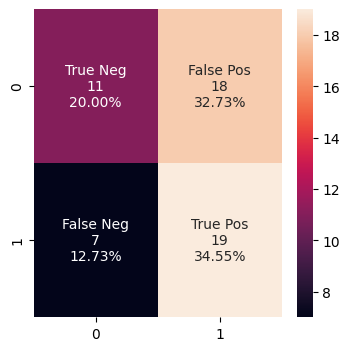

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,lgbm.predict(X_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning]

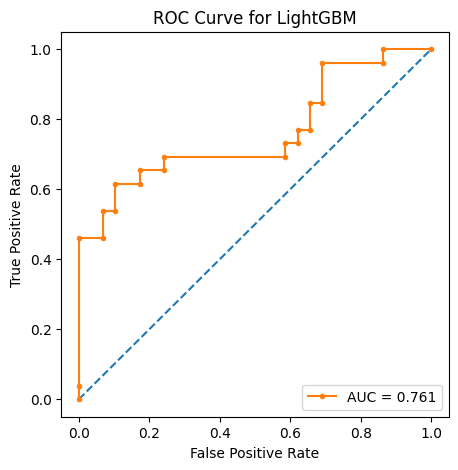

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, lgbm.predict_proba(X_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1]):.3f}")
plt.title("ROC Curve for LightGBM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

<Axes: >

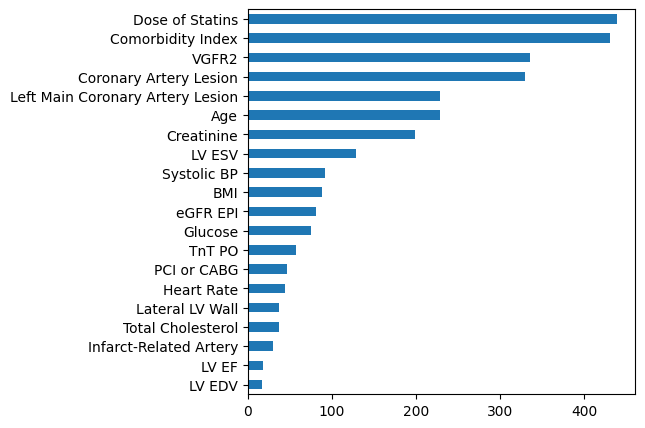

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
(pd.Series(lgbm.feature_importances_, index=X_train.columns)
   .nlargest(20)[::-1]
   .plot(kind='barh'))

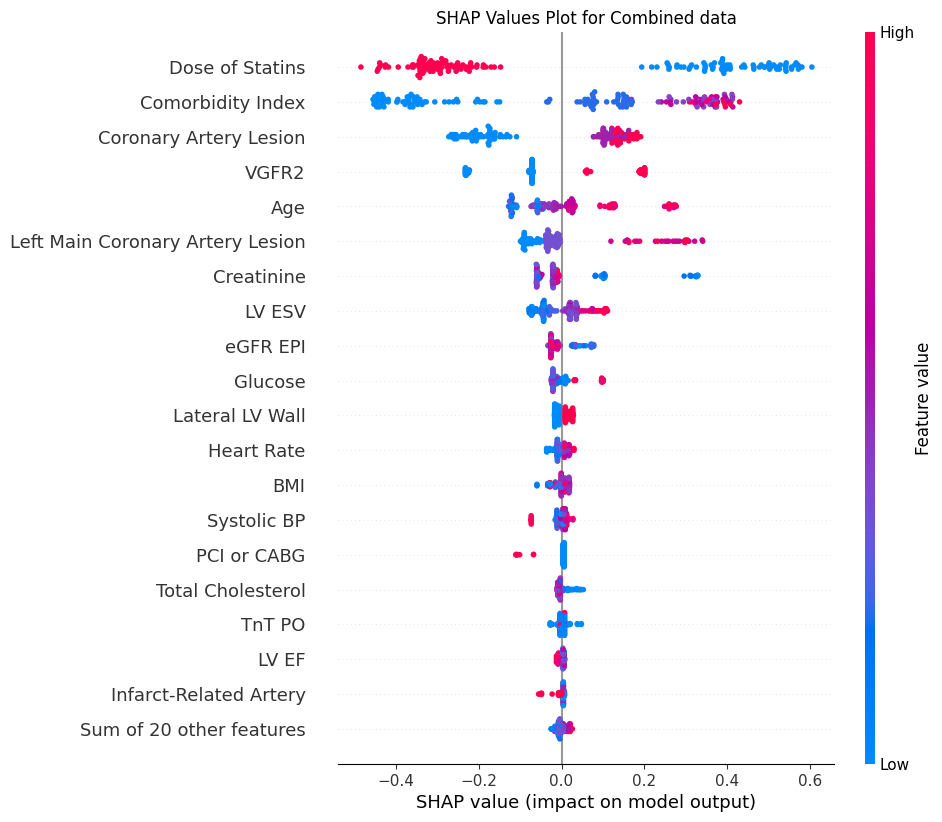

In [ ]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)
plt.title("SHAP Values Plot for Combined data")
shap.plots.beeswarm(explainer(X_train), max_display=20)

# Another models

In [ ]:
X_train = imputed_train[sorted(imputed_train.columns)].copy()
X_test = imputed_test[sorted(imputed_train.columns)].copy()
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

## Random Forest

In [ ]:
def objective(trial):

    model = RandomForestClassifier(
        criterion= trial.suggest_categorical('criterion',['gini', 'entropy']),
        n_estimators=trial.suggest_int( "n_estimators",10, 500),
        max_depth=trial.suggest_int("max_depth", 2,11),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2,100),
        random_state= trial.suggest_categorical('random_state',[random_state]),
        warm_start= trial.suggest_categorical('warm_start',[True,False]),
        class_weight = trial.suggest_categorical('class_weight',[None, 'balanced', 'balanced_subsample']),
        max_features=trial.suggest_float("max_features", 0.5, 1.0),
        max_samples=trial.suggest_float("max_samples", 0.5, 1.0)
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_train,y_train, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_rf_hem_B", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=150)

[I 2024-05-13 11:32:13,878] A new study created in memory with name: ABCD_rf_hem_B
[I 2024-05-13 11:32:14,204] Trial 0 finished with value: 0.8019841269841269 and parameters: {'criterion': 'entropy', 'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 16, 'random_state': 1, 'warm_start': False, 'class_weight': 'balanced_subsample', 'max_features': 0.7095972572016473, 'max_samples': 0.8426097501983798}. Best is trial 0 with value: 0.8019841269841269.
[I 2024-05-13 11:32:14,731] Trial 1 finished with value: 0.6887896825396826 and parameters: {'criterion': 'entropy', 'n_estimators': 23, 'max_depth': 8, 'min_samples_leaf': 43, 'random_state': 1, 'warm_start': True, 'class_weight': 'balanced_subsample', 'max_features': 0.6567120890796214, 'max_samples': 0.846161307834657}. Best is trial 0 with value: 0.8019841269841269.
[I 2024-05-13 11:32:15,656] Trial 2 finished with value: 0.7962301587301587 and parameters: {'criterion': 'entropy', 'n_estimators': 51, 'max_depth': 2, 'min_samples_lea

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.829861111111111

Optimized parameters: {'criterion': 'entropy', 'n_estimators': 18, 'max_depth': 3, 'min_samples_leaf': 12, 'random_state': 1, 'warm_start': True, 'class_weight': None, 'max_features': 0.9852300065329171, 'max_samples': 0.8642062857667152}



In [ ]:
rf = RandomForestClassifier(**best_params)
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=3,
                       max_features=0.9852300065329171,
                       max_samples=0.8642062857667152, min_samples_leaf=12,
                       n_estimators=18, random_state=1, warm_start=True)

In [ ]:
classifiers_predictions = {
    'RF' : rf.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
RF   0.536    0.777     0.645      0.556   0.769  0.228       0.6

In [ ]:
# Saving model
joblib.dump(rf, '/content/drive/MyDrive/1231_ABCD/rf_genetics_vegfr_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/rf_genetics_vegfr_new_feature_new_target_1.joblib']

## Logreg

In [ ]:
# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
float_transformer = StandardScaler()

# Apply transformers to respective features
preprocessor = ColumnTransformer(
    transformers=[
        #('cat', categorical_transformer, sorted(categorical+binary)),
        ('float', float_transformer, numerical)
    ])

# Transform data
X_processed = preprocessor.fit_transform(X_train)
X_processed_test = preprocessor.transform(X_test)

In [ ]:
def objective(trial):

    model = LogisticRegression(
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2']),
        C = trial.suggest_float('C', 0.001, 10, log=True),
        random_state= trial.suggest_categorical('random_state',[random_state]),
        solver = trial.suggest_categorical('solver', ['liblinear'])
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_processed,y_train, cv=kfolds,
        scoring="roc_auc"
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_logreg_genetics", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=150)

[I 2024-05-13 11:38:54,227] A new study created in memory with name: ABCD_logreg_genetics
[I 2024-05-13 11:38:54,284] Trial 0 finished with value: 0.6456349206349208 and parameters: {'penalty': 'l2', 'C': 0.001001053986051049, 'random_state': 1, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6456349206349208.
[I 2024-05-13 11:38:54,336] Trial 1 finished with value: 0.5 and parameters: {'penalty': 'l1', 'C': 0.0023407464805767528, 'random_state': 1, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6456349206349208.
[I 2024-05-13 11:38:54,389] Trial 2 finished with value: 0.6626984126984128 and parameters: {'penalty': 'l2', 'C': 0.03864291653552653, 'random_state': 1, 'solver': 'liblinear'}. Best is trial 2 with value: 0.6626984126984128.
[I 2024-05-13 11:38:54,448] Trial 3 finished with value: 0.6797619047619048 and parameters: {'penalty': 'l1', 'C': 0.5506529897945993, 'random_state': 1, 'solver': 'liblinear'}. Best is trial 3 with value: 0.6797619047619048.
[I 2024-05-13 1

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.6847222222222222

Optimized parameters: {'penalty': 'l1', 'C': 0.26634051056024854, 'random_state': 1, 'solver': 'liblinear'}



In [ ]:
logreg = LogisticRegression(**best_params)
logreg.fit(X_processed,y_train)

LogisticRegression(C=0.26634051056024854, penalty='l1', random_state=1,
                   solver='liblinear')

In [ ]:
# Saving model
joblib.dump(logreg, '/content/drive/MyDrive/1231_ABCD/logreg_genetics_vegfr_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/logreg_genetics_vegfr_new_feature_new_target_1.joblib']

## SVM

In [ ]:
def objective(trial):

    model = SVC(
        C = trial.suggest_float('C', 0.001, 100,log=True),
        kernel = trial.suggest_categorical('kernel', ['rbf','sigmoid']),
        gamma = trial.suggest_float('gamma', 0.001, 10,log=True),
        random_state= trial.suggest_categorical('random_state',[random_state])
    )

    kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

    scores = cross_val_score(
        model, X_train,y_train, cv=kfolds,
        scoring="roc_auc",
        n_jobs=-1
    )
    return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="ABCD_genetics", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=150)

[I 2024-05-13 11:39:02,078] A new study created in memory with name: ABCD_genetics
[I 2024-05-13 11:39:04,321] Trial 0 finished with value: 0.525595238095238 and parameters: {'C': 0.12164941464151847, 'kernel': 'rbf', 'gamma': 0.016193110912440738, 'random_state': 1}. Best is trial 0 with value: 0.525595238095238.
[I 2024-05-13 11:39:04,436] Trial 1 finished with value: 0.5 and parameters: {'C': 0.005417257182767969, 'kernel': 'sigmoid', 'gamma': 0.024112537061475744, 'random_state': 1}. Best is trial 0 with value: 0.525595238095238.
[I 2024-05-13 11:39:04,556] Trial 2 finished with value: 0.5111111111111111 and parameters: {'C': 0.09634681692624379, 'kernel': 'rbf', 'gamma': 0.5506529897945993, 'random_state': 1}. Best is trial 0 with value: 0.525595238095238.
[I 2024-05-13 11:39:04,672] Trial 3 finished with value: 0.5111111111111111 and parameters: {'C': 0.01052594868979971, 'kernel': 'rbf', 'gamma': 0.4806954824961602, 'random_state': 1}. Best is trial 0 with value: 0.5255952380952

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.5863095238095238

Optimized parameters: {'C': 0.719292707076766, 'kernel': 'rbf', 'gamma': 0.040765813109252425, 'random_state': 1}



In [ ]:
svm = SVC(**best_params)
svm.fit(X_train,y_train)

SVC(C=0.719292707076766, gamma=0.040765813109252425, random_state=1)

In [ ]:
# Saving model
joblib.dump(svm, '/content/drive/MyDrive/1231_ABCD/svm_genetics_vegfr_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/svm_genetics_vegfr_new_feature_new_target_1.joblib']

## Results for alternative models

In [ ]:
rf = joblib.load('/content/drive/MyDrive/1231_ABCD/rf_genetics_vegfr_new_feature_new_target_1.joblib')
logreg = joblib.load('/content/drive/MyDrive/1231_ABCD/logreg_genetics_vegfr_new_feature_new_target_1.joblib')
svm = joblib.load('/content/drive/MyDrive/1231_ABCD/svm_genetics_vegfr_new_feature_new_target_1.joblib')
classifiers_predictions = {
    'RF' : rf.predict_proba(X_test)[:,1],
    'Logreg' : logreg.predict_proba(X_processed_test)[:,1],
    'SVM' : svm.predict(X_test)
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
RF       0.536    0.777     0.645      0.556   0.769  0.228     0.600
Logreg   0.473    0.614     0.562      0.474   0.692  0.003     0.491
SVM      0.473    0.500     0.642      0.473   1.000  0.000     0.473

<Axes: >

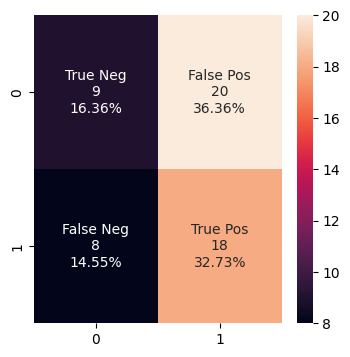

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix_cb = confusion_matrix(y_test,logreg.predict(X_processed_test))
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix_cb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_cb.flatten()/np.sum(cf_matrix_cb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cf_matrix_cb, annot=labels, fmt='')

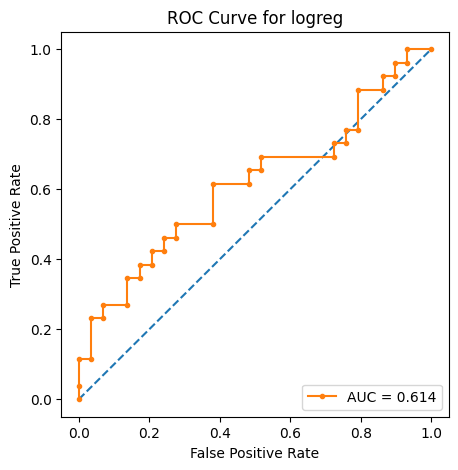

In [ ]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, logreg.predict_proba(X_processed_test)[:,1])
f, ax = plt.subplots(figsize=(5, 5))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, logreg.predict_proba(X_processed_test)[:,1]):.3f}")
plt.title("ROC Curve for logreg")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

# Catboost

In [ ]:
X_train = imputed_train[sorted(cols_to_use)].copy()
X_test = imputed_test[sorted(cols_to_use)].copy()
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

## Main model

In [ ]:
def objective(trial):

# Define the parameters dictionary using suggestions from a hyperparameter optimization trial
  params = {
    "objective": trial.suggest_categorical("objective", ["Logloss"]),
    "iterations": trial.suggest_categorical("iterations", [1000]),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
    "depth": trial.suggest_int("depth", 2, 8),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 150.0, log=True),
    "random_strength": trial.suggest_float("random_strength", 1e-1, 10.0, log=True),
    "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced", "SqrtBalanced"]),
    "verbose": False,
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    "rsm": trial.suggest_float("rsm", 0.3, 1.0),
    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
    }

  if params["bootstrap_type"] == "Bayesian":
    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif params["bootstrap_type"] == "Bernoulli":
    params["subsample"] = trial.suggest_float("subsample", 0.1, 0.9)

  model = CatBoostClassifier(**params)

  kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

  scores = cross_val_score(
        model, X_train, y_train, cv=kfolds,
        scoring="roc_auc"
    )
  return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_genetics", direction="maximize",sampler = sampler)

study.optimize(objective, n_trials=150)

[I 2024-05-13 11:39:30,302] A new study created in memory with name: catboost_genetics
[I 2024-05-13 11:40:22,689] Trial 0 finished with value: 0.7861111111111111 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.003487802515319415, 'depth': 7, 'l2_leaf_reg': 0.10008367981663674, 'random_strength': 0.402406646471461, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'Lossguide', 'rsm': 0.5934361600823064, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.781174363909454}. Best is trial 0 with value: 0.7861111111111111.
[I 2024-05-13 11:40:51,907] Trial 1 finished with value: 0.8339285714285714 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.00012627165880121756, 'depth': 6, 'l2_leaf_reg': 2.1154274483309874, 'random_strength': 1.3103269001464433, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'SymmetricTree', 'rsm': 0.9134724066072268, 'bootstrap_type': 'Bayesian', 'bagging

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8402777777777777

Optimized parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.00010738392563673446, 'depth': 4, 'l2_leaf_reg': 0.9937108627857411, 'random_strength': 0.5979018950565215, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'Lossguide', 'rsm': 0.8512027442274449, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.19198403592454305}



In [ ]:
catboost = CatBoostClassifier(**best_params)
catboost.fit(X_train,y_train)

0:	learn: 0.6930822	total: 2.56ms	remaining: 2.56s
1:	learn: 0.6930327	total: 5.32ms	remaining: 2.66s
2:	learn: 0.6929589	total: 7.74ms	remaining: 2.57s
3:	learn: 0.6928954	total: 10.2ms	remaining: 2.53s
4:	learn: 0.6928439	total: 12.5ms	remaining: 2.48s
5:	learn: 0.6927472	total: 14.9ms	remaining: 2.47s
6:	learn: 0.6926492	total: 17.3ms	remaining: 2.46s
7:	learn: 0.6925829	total: 19.8ms	remaining: 2.45s
8:	learn: 0.6924981	total: 22.5ms	remaining: 2.47s
9:	learn: 0.6924340	total: 25ms	remaining: 2.47s
10:	learn: 0.6923787	total: 27.7ms	remaining: 2.49s
11:	learn: 0.6923143	total: 30.3ms	remaining: 2.5s
12:	learn: 0.6922456	total: 32.7ms	remaining: 2.48s
13:	learn: 0.6921917	total: 35.3ms	remaining: 2.49s
14:	learn: 0.6921267	total: 37.3ms	remaining: 2.45s
15:	learn: 0.6920770	total: 39.7ms	remaining: 2.44s
16:	learn: 0.6920005	total: 42.1ms	remaining: 2.44s
17:	learn: 0.6919545	total: 44.6ms	remaining: 2.43s
18:	learn: 0.6918910	total: 46.8ms	remaining: 2.42s
19:	learn: 0.6918400	tota

In [ ]:
classifiers_predictions = {
    'Catboost' : catboost.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
Catboost   0.537    0.786     0.656      0.553   0.808  0.239       0.6

In [ ]:
# Saving model
joblib.dump(catboost, '/content/drive/MyDrive/1231_ABCD/catboost_genetics_vegfr_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/catboost_genetics_vegfr_new_feature_new_target_1.joblib']

## SFS

In [ ]:
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_genetics_vegfr_new_feature_new_target_1.joblib')

In [ ]:
params = catboost.get_params()
params['logging_level'] = 'Silent'

In [ ]:
catboost = CatBoostClassifier(**params)
catboost.fit(X_train,y_train)

In [ ]:
sfsl = SFS(estimator = catboost, forward = True, k_features = (1,len(X_train.columns)), floating=False, scoring = 'roc_auc', cv=5, verbose=1,n_jobs=2)
sfsl.fit(X_train,y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  39 out of  39 | elapsed:  2.2min finished
Features: 1/39[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  38 out of  38 | elapsed:  2.5min finished
Features: 2/39[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 out of  37 | elapsed:  2.4min finished
Features: 3/39[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:  2.5min finished
Features: 4/39[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:  2.4min finished
Features: 5/39[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  34 out of  34 | elapsed:  2.6min finished
Features: 6/39[Parallel(n_jobs=2)]: Using backend LokyBacken

SequentialFeatureSelector(estimator=<catboost.core.CatBoostClassifier object at 0x7f8550c53cd0>,
                          k_features=(1, 39), n_jobs=2, scoring='roc_auc',
                          verbose=1)

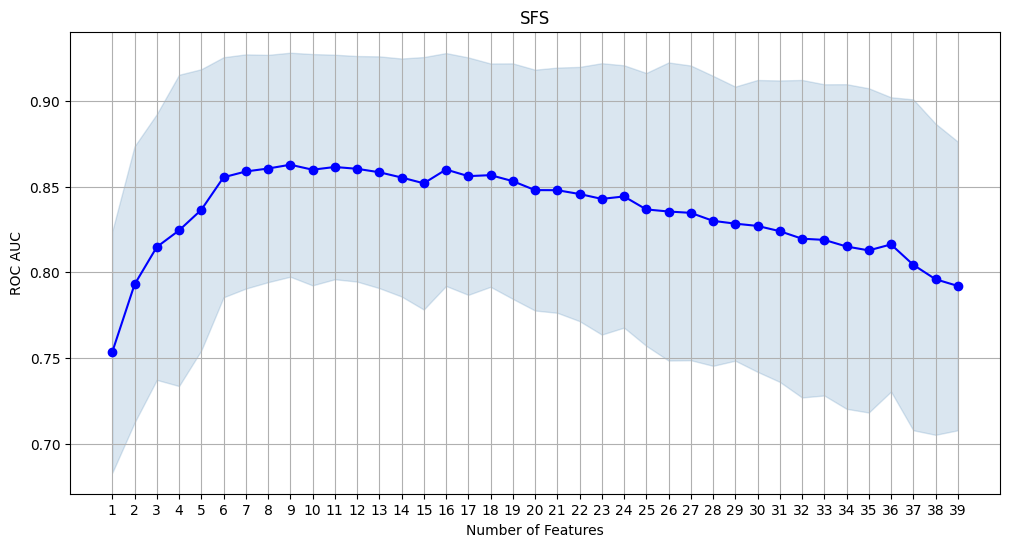

In [ ]:
#sfsl = SFS(estimator = catboost, forward = True, k_features = (1,len(X_train.columns)), floating=False, scoring = 'roc_auc', cv=5, verbose=1,n_jobs=2)
metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip')
fig1 = plot_sfs(metric_dict,kind = 'std_dev',figsize=(12,6))
plt.title('SFS')
plt.ylabel('ROC AUC')
plt.grid()
plt.savefig('images/fig2.pdf')
plt.show()

In [ ]:
joblib.dump(sfsl.get_metric_dict(), '/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip')

['/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip']

In [ ]:
scores = [element['avg_score'] for element in sfsl.get_metric_dict().values()]
best_combination_index = np.argmax(scores) + 1
best_combination = sfsl.get_metric_dict()[best_combination_index]['feature_names']
print('Best number of features: ', len(best_combination))
print(sfsl.get_metric_dict()[best_combination_index])
print('Features: ', best_combination)

Best number of features:  9
{'feature_idx': (4, 6, 7, 10, 12, 25, 27, 28, 37), 'cv_scores': array([0.84814815, 0.82592593, 0.81851852, 0.82936508, 0.99206349]), 'avg_score': 0.8628042328042328, 'feature_names': ('BMI', 'Comorbidity Index', 'Coronary Artery Lesion', 'Dose of Statins', 'Gender', 'Lateral LV Wall', 'Left Main Coronary Artery Lesion', 'PCI or CABG', 'VGFR2'), 'ci_bound': 0.08401156963024647, 'std_dev': 0.0653638553214733, 'std_err': 0.03268192766073665}
Features:  ('BMI', 'Comorbidity Index', 'Coronary Artery Lesion', 'Dose of Statins', 'Gender', 'Lateral LV Wall', 'Left Main Coronary Artery Lesion', 'PCI or CABG', 'VGFR2')


## Model on subset

In [ ]:
metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = sorted(best_combination)

In [ ]:
X_train = imputed_train[s].copy()
X_test = imputed_test[s].copy()
new_cat_features = sorted([column for column in X_train.columns if column in cat_features])
X_train[new_cat_features] = X_train[new_cat_features].astype(int)
X_test[new_cat_features] = X_test[new_cat_features].astype(int)
# y_train,y_test = train['combined'], test['combined']

In [ ]:
def objective(trial):

# Define the parameters dictionary using suggestions from a hyperparameter optimization trial
  params = {
    "objective": trial.suggest_categorical("objective", ["Logloss"]),
    "iterations": trial.suggest_categorical("iterations", [1000]),
    "learning_rate": trial.suggest_float("learning_rate", 1e-4, 5e-1, log=True),
    "depth": trial.suggest_int("depth", 2, 8),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-1, 150.0, log=True),
    "random_strength": trial.suggest_float("random_strength", 1e-1, 10.0, log=True),
    "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced", "SqrtBalanced"]),
    "verbose": False,
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
    "rsm": trial.suggest_float("rsm", 0.3, 1.0),
    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"])
    }

  if params["bootstrap_type"] == "Bayesian":
    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif params["bootstrap_type"] == "Bernoulli":
    params["subsample"] = trial.suggest_float("subsample", 0.1, 0.9)

  model = CatBoostClassifier(**params)

  kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

  scores = cross_val_score(
        model, X_train, y_train, cv=kfolds,
        scoring="roc_auc"
    )
  return scores.mean()

In [ ]:
sampler = optuna.samplers.TPESampler(seed = random_state)
study = optuna.create_study(study_name="catboost_selected_genetics", direction="maximize",sampler = sampler)
study.optimize(objective, n_trials=150)

[I 2024-05-13 15:50:45,067] A new study created in memory with name: catboost_selected_genetics
[I 2024-05-13 15:51:02,928] Trial 0 finished with value: 0.8539682539682542 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.003487802515319415, 'depth': 7, 'l2_leaf_reg': 0.10008367981663674, 'random_strength': 0.402406646471461, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'Lossguide', 'rsm': 0.5934361600823064, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.781174363909454}. Best is trial 0 with value: 0.8539682539682542.
[I 2024-05-13 15:51:13,149] Trial 1 finished with value: 0.8476190476190476 and parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.00012627165880121756, 'depth': 6, 'l2_leaf_reg': 2.1154274483309874, 'random_strength': 1.3103269001464433, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'SymmetricTree', 'rsm': 0.9134724066072268, 'bootstrap_type': 'Bayesian',

In [ ]:
best_params = study.best_params
best_score = study.best_value
print(f"Best score: {best_score}\n")
print(f"Optimized parameters: {best_params}\n")

Best score: 0.8817460317460316

Optimized parameters: {'objective': 'Logloss', 'iterations': 1000, 'learning_rate': 0.0009751543087096023, 'depth': 5, 'l2_leaf_reg': 0.2246764056263978, 'random_strength': 0.49626994827655696, 'auto_class_weights': 'SqrtBalanced', 'random_state': 1, 'grow_policy': 'Lossguide', 'rsm': 0.5486307929699922, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7368559252313748}



In [ ]:
catboost_selected = CatBoostClassifier(**best_params)
catboost_selected.fit(X_train,y_train)

0:	learn: 0.6925499	total: 1.88ms	remaining: 1.88s
1:	learn: 0.6917878	total: 7.49ms	remaining: 3.74s
2:	learn: 0.6909315	total: 8.69ms	remaining: 2.89s
3:	learn: 0.6903854	total: 9.91ms	remaining: 2.47s
4:	learn: 0.6896195	total: 11.3ms	remaining: 2.24s
5:	learn: 0.6888989	total: 12.6ms	remaining: 2.08s
6:	learn: 0.6882500	total: 13.8ms	remaining: 1.96s
7:	learn: 0.6875553	total: 15ms	remaining: 1.86s
8:	learn: 0.6865564	total: 16.3ms	remaining: 1.79s
9:	learn: 0.6861888	total: 17.3ms	remaining: 1.71s
10:	learn: 0.6854598	total: 18.5ms	remaining: 1.67s
11:	learn: 0.6847567	total: 19.8ms	remaining: 1.63s
12:	learn: 0.6839571	total: 21.1ms	remaining: 1.6s
13:	learn: 0.6831643	total: 22.4ms	remaining: 1.57s
14:	learn: 0.6820656	total: 23.7ms	remaining: 1.55s
15:	learn: 0.6815537	total: 24.9ms	remaining: 1.53s
16:	learn: 0.6809669	total: 26.1ms	remaining: 1.51s
17:	learn: 0.6802955	total: 27.3ms	remaining: 1.49s
18:	learn: 0.6795768	total: 28.4ms	remaining: 1.47s
19:	learn: 0.6789106	tota

In [ ]:
classifiers_predictions = {
    'Catboost' : catboost_selected.predict_proba(X_test)[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
Catboost   0.622    0.813     0.714      0.667   0.769  0.426     0.709

In [ ]:
# Saving model
joblib.dump(catboost_selected, '/content/drive/MyDrive/1231_ABCD/catboost_selected_genetics_vegfr_new_feature_new_target_1.joblib')

['/content/drive/MyDrive/1231_ABCD/catboost_selected_genetics_vegfr_new_feature_new_target_1.joblib']

# Model on 2 features

In [ ]:
X_train = imputed_train[sorted(imputed_train.columns)].copy()
X_test = imputed_test[sorted(imputed_train.columns)].copy()
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)
s = sorted(['Dose of Statins','VGFR2'])

In [ ]:
catboost = CatBoostClassifier()
catboost.fit(X_train[s],y_train)

In [ ]:
classifiers_predictions = {
    'Catboost' : catboost.predict_proba(X_train[s])[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_train,pred_),3),
                         round(roc_auc_score(y_train,pred),3),
                          round(f1_score(y_train,pred_),3),
                          round(precision_score(y_train,pred_),3),
                          round(recall_score(np.asarray(y_train.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_train.values),pred_),3),
                          np.round(accuracy_score(y_train,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

In [ ]:
classifiers_predictions = {
    'Catboost' : catboost.predict_proba(X_test[s])[:,1]
}
classifiers_results = pd.DataFrame(columns=['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy'])

for method,pred in classifiers_predictions.items():
    pred_ = pred.round()
    classifiers_results.loc[method]= [round(average_precision_score(y_test,pred_),3),
                         round(roc_auc_score(y_test,pred),3),
                          round(f1_score(y_test,pred_),3),
                          round(precision_score(y_test,pred_),3),
                          round(recall_score(np.asarray(y_test.values),pred_),3),
                          round(matthews_corrcoef(np.asarray(y_test.values),pred_),3),
                          np.round(accuracy_score(y_test,pred_),decimals=4)]
classifiers_results.sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

PR_AUC  ROC_AUC  F1-score  Precision  Recall    MCC  Accuracy
Catboost   0.575    0.775     0.655      0.621   0.692  0.313     0.654

In [ ]:
# Saving model
joblib.dump(catboost, '/content/drive/MyDrive/1231_ABCD/catboost_strat_genetics_vegfr_2f_new_target_unstratified_1.joblib')

['/content/drive/MyDrive/1231_ABCD/catboost_strat_genetics_vegfr_2f_new_target_unstratified_1.joblib']

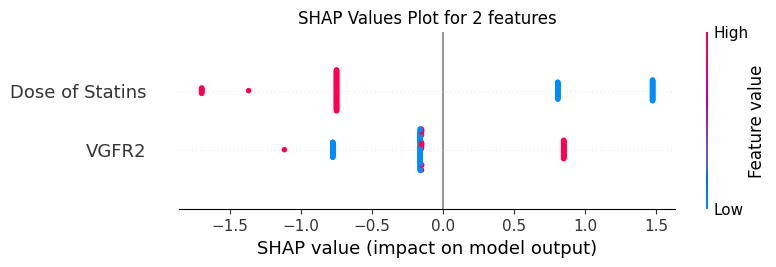

In [ ]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_train[s])
plt.title("SHAP Values Plot for 2 features")
shap.plots.beeswarm(explainer(X_train[s]), max_display=20)

# Final results evaluation with bootstrap

In [ ]:
cat_features = categorical

In [ ]:
from sklearn.metrics import auc,precision_recall_curve

In [ ]:
def evaluate_metrics(classifiers, X_test, y_test, num_bootstrap=1000, random_state=random_state):
    metrics = ['PR_AUC', 'ROC_AUC', 'F1-score', 'Precision', 'Recall', 'MCC', 'Accuracy']
    results = {}

    for clf_name, clf in classifiers.items():
        metric_scores = []
        for i in range(num_bootstrap):
            # Initialize random number generator
            rng = np.random.default_rng(random_state + i)

            # Bootstrap resampling
            num_samples = len(X_test)
            bootstrap_indices = rng.choice(num_samples, num_samples, replace=True)
            X_bootstrap = X_test.iloc[bootstrap_indices]
            y_bootstrap = y_test.iloc[bootstrap_indices]

            # Handle the case when only one class is present in y_bootstrap
            if len(np.unique(y_bootstrap)) == 1:
                continue

            if clf_name!='SVM':
              # Predict probabilities
              y_prob = clf.predict_proba(X_bootstrap)[:, 1]

            else:
              y_prob = clf.predict(X_bootstrap)

            # Calculate metrics
            y_prob_round = y_prob.round()
            pr,rec,tres = precision_recall_curve(y_bootstrap, y_prob)
            pr_auc = auc(rec,pr)
            roc_auc = roc_auc_score(y_bootstrap, y_prob)
            f1 = f1_score(y_bootstrap, y_prob_round)
            precision = precision_score(y_bootstrap, y_prob_round)
            recall = recall_score(y_bootstrap, y_prob_round)
            mcc = matthews_corrcoef(y_bootstrap, y_prob_round)
            accuracy = accuracy_score(y_bootstrap, y_prob_round)

            metric_scores.append((pr_auc, roc_auc, f1, precision, recall, mcc, accuracy))

        metric_scores = np.array(metric_scores)
        mean_scores = np.mean(metric_scores, axis=0)
        results[clf_name] = mean_scores

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)
    return results_df

In [ ]:
X_train = imputed_train[sorted(imputed_train.columns)].copy()
X_test = imputed_test[sorted(imputed_train.columns)].copy()
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

In [ ]:
baseline = joblib.load('/content/drive/MyDrive/1231_ABCD/baseline_genetics_new_feature_new_target_1.pkl')
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_genetics_vegfr_new_feature_new_target_1.joblib')
catboost_selected = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_selected_genetics_vegfr_new_feature_new_target_1.joblib')
rf = joblib.load('/content/drive/MyDrive/1231_ABCD/rf_genetics_vegfr_new_feature_new_target_1.joblib')
logreg = joblib.load('/content/drive/MyDrive/1231_ABCD/logreg_genetics_vegfr_new_feature_new_target_1.joblib')
svm = joblib.load('/content/drive/MyDrive/1231_ABCD/svm_genetics_vegfr_new_feature_new_target_1.joblib')
lgbm_model = joblib.load('/content/drive/MyDrive/1231_ABCD/lgbm_genetics_new_feature_new_target_1.joblib')
catboost_2_features = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_strat_genetics_vegfr_2f_new_target_unstratified_1.joblib')

metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = list(best_combination)
s5 = ['Dose of Statins', 'Glucose', 'LV ESV', 'VGFR2']
s2 = sorted(['Dose of Statins','VGFR2'])

X_train_sfs,X_test_sfs = X_train[s].copy(), X_test[s].copy()
X_train_5,X_test_5 = X_train[s5].copy(), X_test[s5].copy()
X_train_2,X_test_2 = X_train[s2].copy(), X_test[s2].copy()

In [ ]:
classifiers = {
    'Catboost' : catboost
}
cat = evaluate_metrics(classifiers,X_test,y_test)

classifiers = {
    'Catboost after SFS' : catboost_selected
}
selected = evaluate_metrics(classifiers,X_test_sfs,y_test)
classifiers = {
    'RandomForest' : rf
}
rf_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'Logistic Regression' : logreg
}
logreg_ = evaluate_metrics(classifiers,pd.DataFrame(X_processed_test),y_test)
classifiers = {
    'SVM' : svm
}
svm_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'AutoMl Baseline' : baseline
}
automl = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'LightGBM' : lgbm_model
}
lgbm_ = evaluate_metrics(classifiers,X_test,y_test)
classifiers = {
    'Catboost with Statins + VGFR2' : catboost_2_features
}
catboost_categorical_2 = evaluate_metrics(classifiers,X_test_2,y_test)

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning]

In [ ]:
res = pd.concat([cat,selected,rf_,logreg_,automl,lgbm_,catboost_categorical_2])

In [ ]:
res.round(3).sort_values(by=['ROC_AUC','PR_AUC'],ascending=False).style.highlight_max()

In [ ]:
y_train.value_counts(1),y_test.value_counts(1)

(combined
 1    0.552
 0    0.448
 Name: proportion, dtype: float64,
 combined
 0    0.527
 1    0.473
 Name: proportion, dtype: float64)

In [ ]:
# Save the DataFrame to a CSV file
X_train_sfs.to_csv('X_train.csv', index=True)

# Pictures

## Shaps

### Best

In [ ]:
cat_features = ['Comorbidity Index', 'Coronary Artery Lesion', 'Duration of Pain', 'Infarct-Related Artery', 'Killip Class', 'Left Main Coronary Artery Lesion', 'TIMI Grade in Infarct-Related Artery', 'VEGFR2 Genotype']

In [ ]:
X_train_sfs = X_train_sfs.rename(columns={'VGFR2':'VEGFR2 Genotype','History' : 'Family history of CVD', 'Atherosclerosis' : 'Multifocal Atherosclerosis','Dose of Statins':'Statin Dosage'})
X_test_sfs = X_train_sfs.rename(columns={'VGFR2':'VEGFR2 Genotype','History' : 'Family history of CVD', 'Atherosclerosis' : 'Multifocal Atherosclerosis','Dose of Statins':'Statin Dosage'})

In [ ]:
catboost_graphs = CatBoostClassifier(**catboost_selected.get_params())
catboost_graphs.fit(X_train_sfs,y_train)

0:	learn: 0.6925499	total: 2.15ms	remaining: 2.14s
1:	learn: 0.6917878	total: 3.75ms	remaining: 1.87s
2:	learn: 0.6909315	total: 5.11ms	remaining: 1.7s
3:	learn: 0.6903854	total: 6.24ms	remaining: 1.55s
4:	learn: 0.6896195	total: 7.6ms	remaining: 1.51s
5:	learn: 0.6888989	total: 8.82ms	remaining: 1.46s
6:	learn: 0.6882500	total: 10ms	remaining: 1.42s
7:	learn: 0.6875553	total: 11.3ms	remaining: 1.4s
8:	learn: 0.6865564	total: 12.5ms	remaining: 1.37s
9:	learn: 0.6861888	total: 13.4ms	remaining: 1.33s
10:	learn: 0.6854598	total: 14.5ms	remaining: 1.31s
11:	learn: 0.6847567	total: 15.7ms	remaining: 1.29s
12:	learn: 0.6839571	total: 17ms	remaining: 1.29s
13:	learn: 0.6831643	total: 18.2ms	remaining: 1.28s
14:	learn: 0.6820656	total: 19.4ms	remaining: 1.27s
15:	learn: 0.6815537	total: 20.6ms	remaining: 1.26s
16:	learn: 0.6809669	total: 21.6ms	remaining: 1.25s
17:	learn: 0.6802955	total: 23.1ms	remaining: 1.26s
18:	learn: 0.6795768	total: 25.2ms	remaining: 1.3s
19:	learn: 0.6789106	total: 26

Conventional

In [ ]:
explainer = shap.TreeExplainer(catboost_graphs)

In [ ]:
explanation_all = explainer(X_train_sfs)

In [ ]:
right_feature_names = X_train_sfs.rename(columns={'VGFR2':'VEGFR2 Genotype',
                                                  'History' : 'Family history of CVD',
                                                  'Atherosclerosis' : 'Multifocal Atherosclerosis',
                                                  'Dose of Statins':'Statin Dosage',
                                                  'Lateral LV Wall':'Lateral LV Wall Involvement in MI',
                                                  'PCI or CABG':'CABG or PCI',
                                                  #'Gender': 'Gender (Male or Female)'
                                                  }).columns.values

In [ ]:
exp = shap.Explanation(explanation_all.values,
                  explanation_all.base_values,
                  data=explanation_all.data,
                  feature_names=right_feature_names)

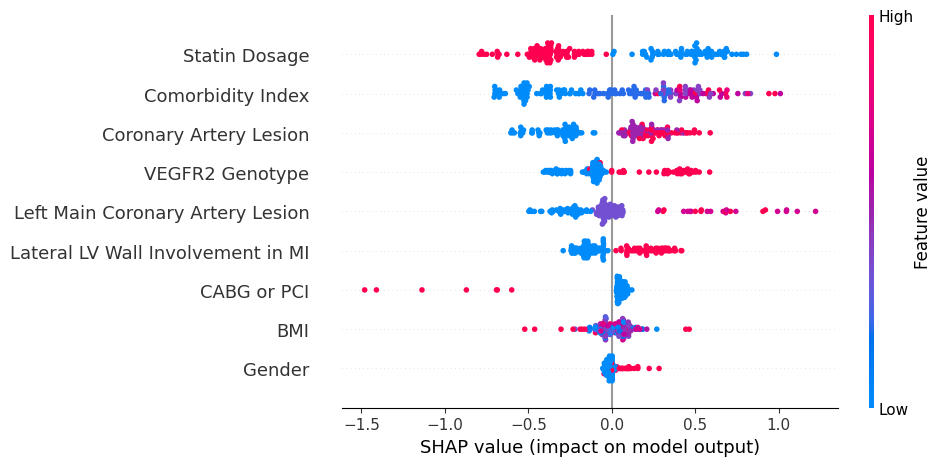

In [ ]:
shap.plots.beeswarm(exp, max_display=11,show=False)

plt.savefig('images/fig3.png',dpi=300)

In [ ]:
from PIL import Image
# Open the image file
image = Image.open('images/fig3.png')
# Get the DPI of the image
dpi = image.info['dpi']
# Print the DPI
print(f"The DPI of the image is: {dpi}")

The DPI of the image is: (299.9994, 299.9994)


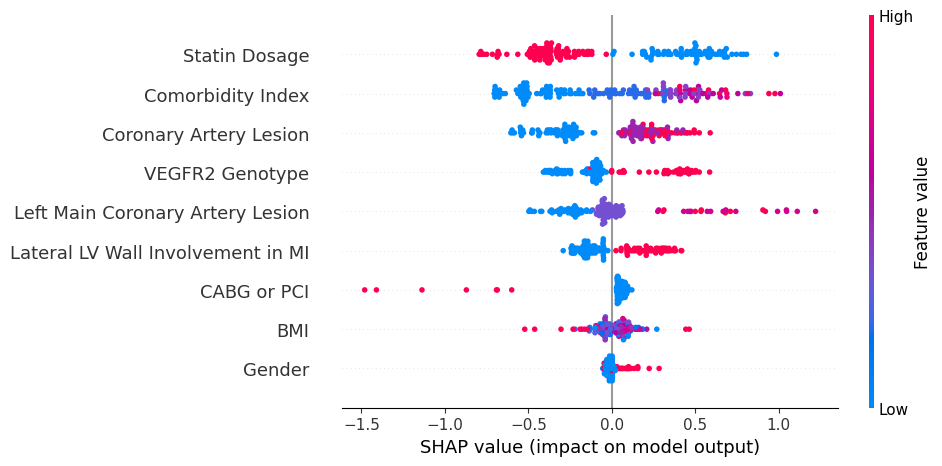

In [ ]:
shap.plots.beeswarm(exp, max_display=11)

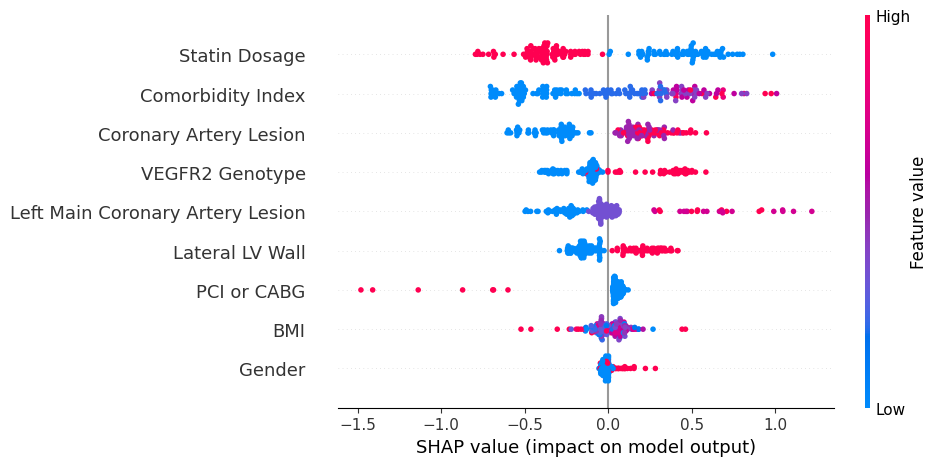

In [ ]:
explainer = shap.TreeExplainer(catboost_graphs)
shap_values = explainer.shap_values(X_train_sfs)
#plt.title("SHAP Values Plot for Catboost on features subset")
shap.plots.beeswarm(explainer(X_train_sfs), max_display=11)

Absolute

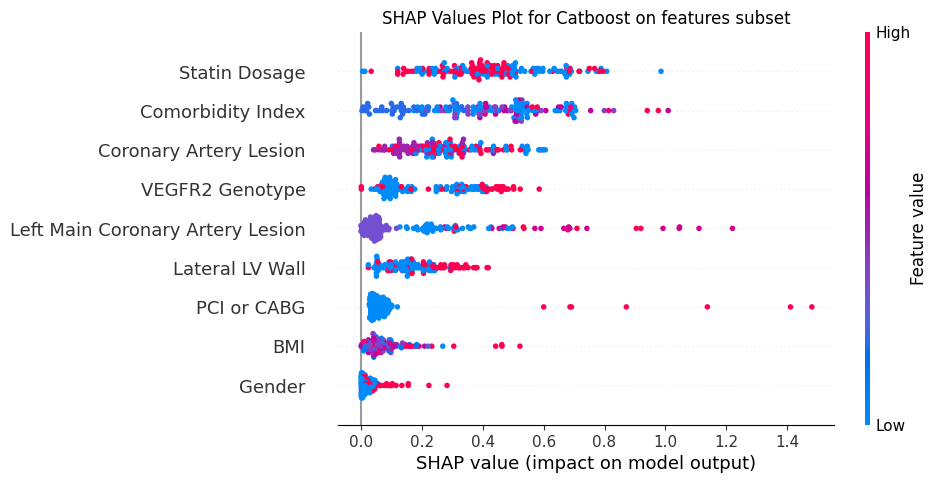

In [ ]:
plt.title("SHAP Values Plot for Catboost on features subset")
shap.plots.beeswarm(explainer(X_train_sfs).abs,max_display=11)

One-sided

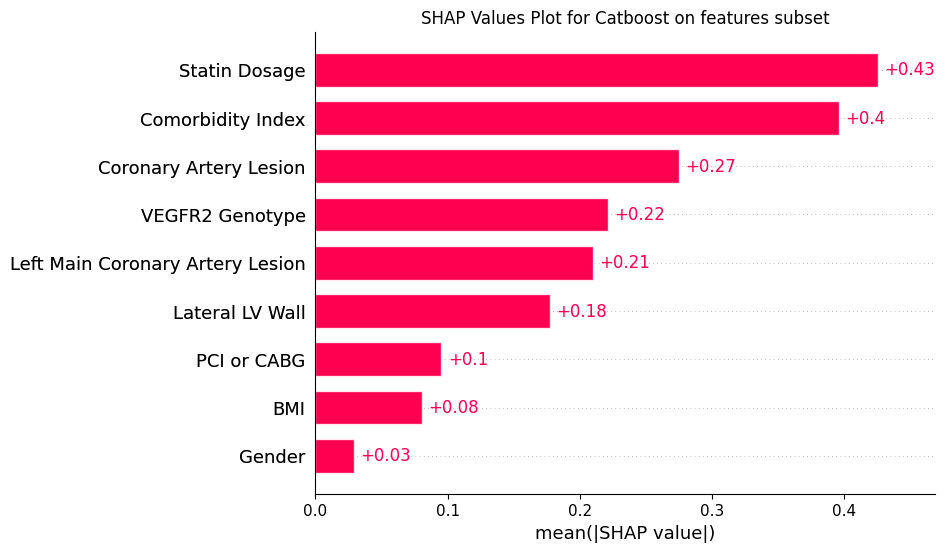

In [ ]:
plt.title("SHAP Values Plot for Catboost on features subset")
shap.plots.bar(explainer(X_train_sfs).abs.mean(0),max_display=11)

Max Risk

In [ ]:
probs = catboost_graphs.predict_proba(X_train_sfs)[:,1]
min_index = np.argmin(probs)
max_index = np.argmax(probs)

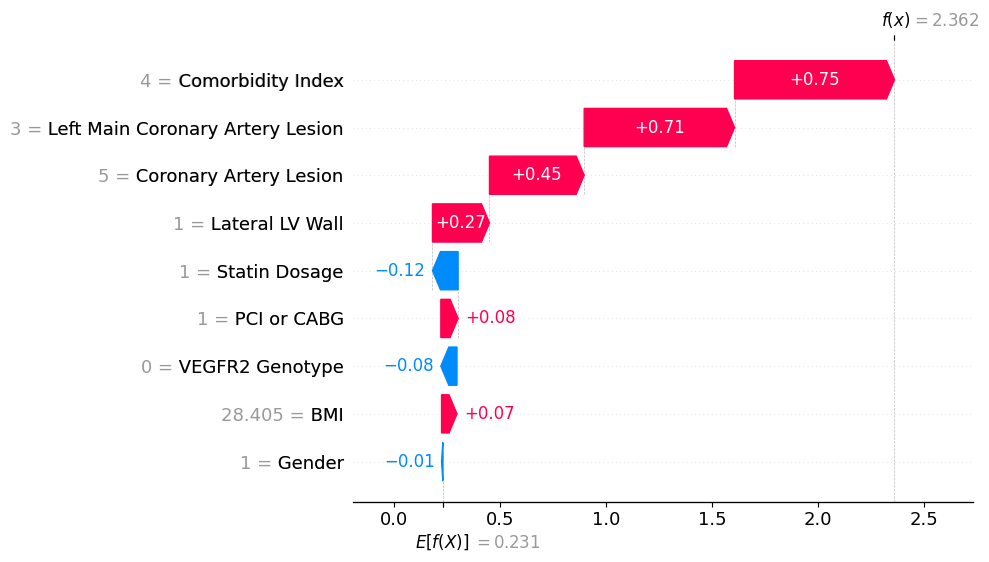

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[max_index],max_display=11)

Min Risk

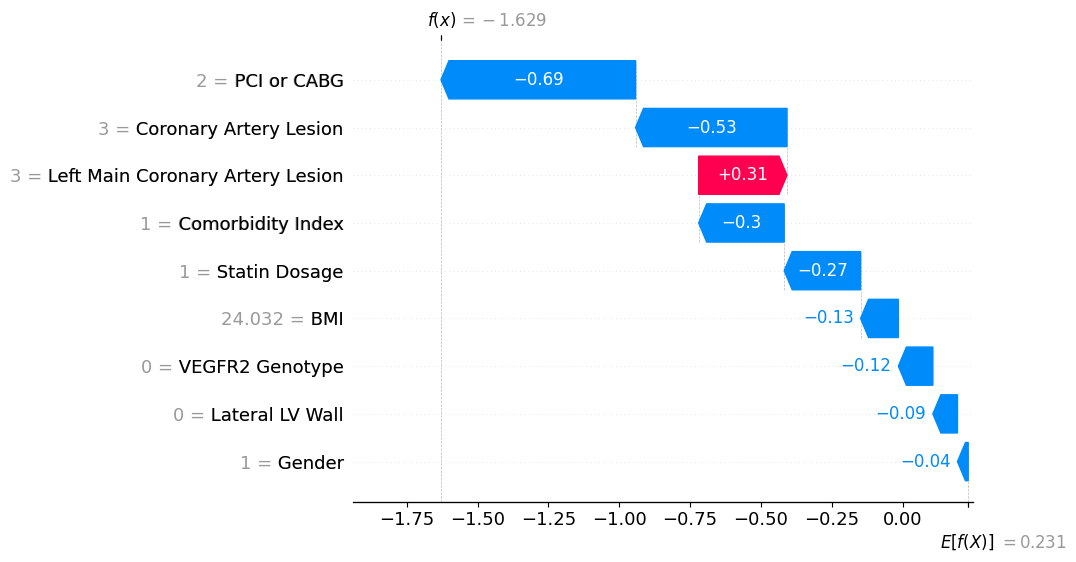

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[min_index],max_display=11)

In [ ]:
shap.plots.initjs()
shap.plots.force(explainer(X_train_sfs)[max_index],link='logit')

In [ ]:
shap.plots.initjs()
shap.plots.force(explainer(X_train_sfs)[min_index],link='logit')

### Custom shap

In [ ]:
probs = catboost_graphs.predict_proba(X_train_sfs)[:,1]
min_index = np.argmin(probs)
max_index = np.argmax(probs)

In [ ]:
max_index

23

In [ ]:
min_index

58

In [ ]:
risk_indexes = np.argsort(probs)

In [ ]:
risk_indexes[-2]

137

In [ ]:
explainer = shap.TreeExplainer(catboost_graphs)

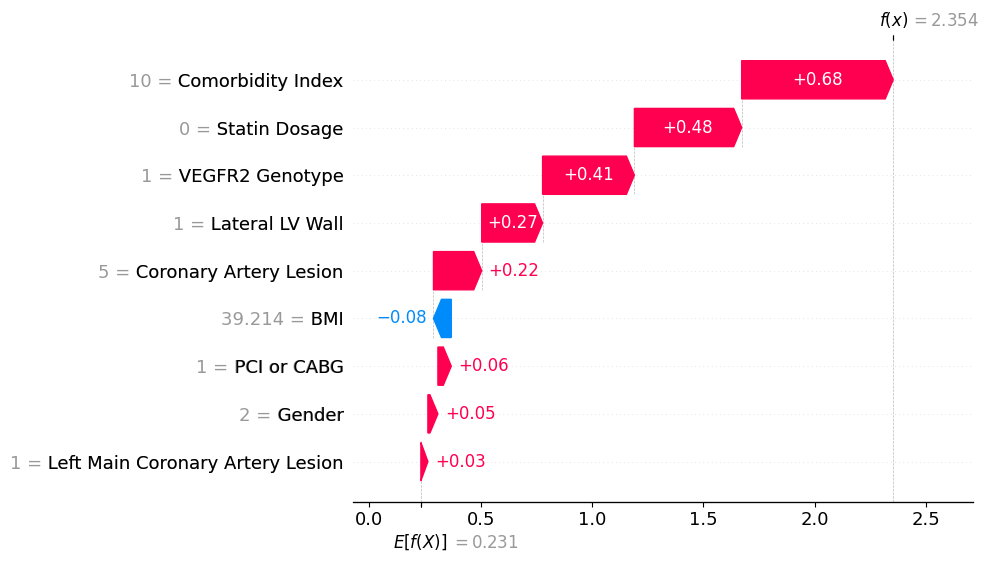

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[risk_indexes[-3]],max_display=11)

In [ ]:
X_train_sfs['Left Main Coronary Artery Lesion'].value_counts()

Left Main Coronary Artery Lesion
1    88
0    49
2    17
3     9
Name: count, dtype: int64

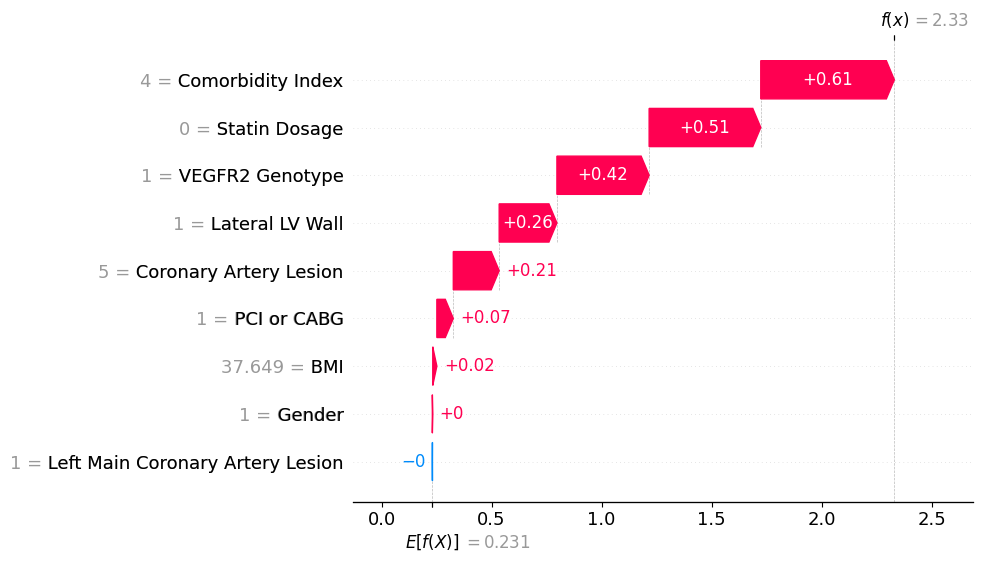

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[risk_indexes[-4]],max_display=11)

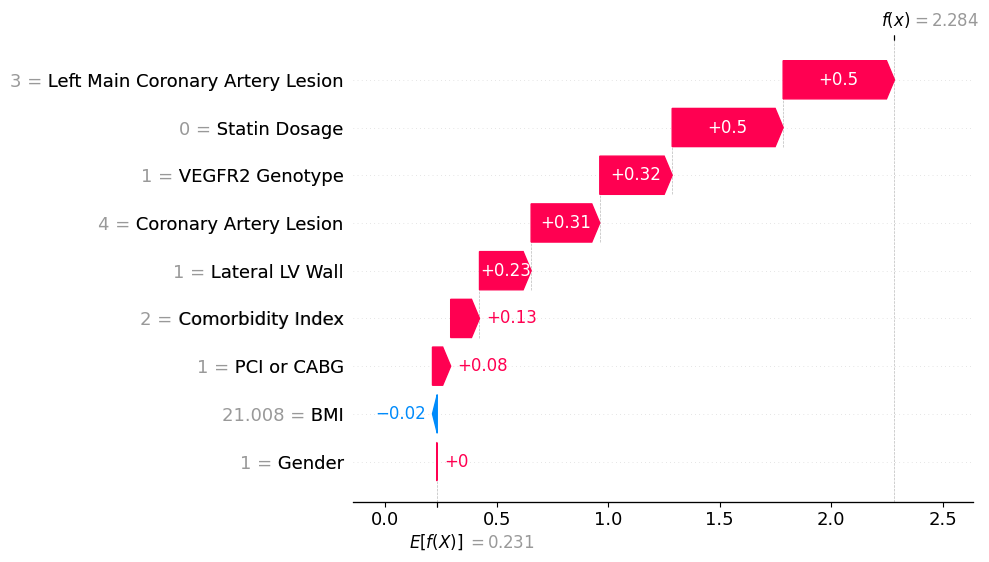

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[risk_indexes[-5]],max_display=11)

In [ ]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
def convert_shaps_to_probs(shap_values, expected_value, proba):
  return np.asarray(shap_values)/np.sum(shap_values) * (proba - sigmoid(expected_value)), sigmoid(expected_value)

In [ ]:
def make_plot(data, index, feature_values, feature_names, display=20,save=True,path=''):
  probs = catboost_graphs.predict_proba(data)[:,1]
  exp_for_plot = explainer(data)
  values, exp_value = convert_shaps_to_probs(exp_for_plot[index].values,exp_for_plot[index].base_values,probs[index])
  values = np.asarray(values)
  values[values==0.] = 0.
  exp = shap.Explanation(values,
                  exp_value,
                  data=feature_values,
                  feature_names=data.columns)
  return waterfall(exp,max_display=display,save=save,path=path)


In [ ]:
right_values = np.asarray(['Overweighted Patient (BMI = 28 kg/m2)','High Charlson Comorbidity Index (Score 4)',
                           'Multivessel','High Intensity Dosage','Male',
                           'Involved','Critical (> 50%)','PCI',
                           'Wild (C/C)'
                           ])

In [ ]:
right_feature_names

array(['BMI', 'Comorbidity Index', 'Coronary Artery Lesion',
       'Statin Dosage', 'Gender', 'Lateral LV Wall Involvement in MI',
       'Left Main Coronary Artery Lesion', 'CABG or PCI',
       'VEGFR2 Genotype'], dtype=object)

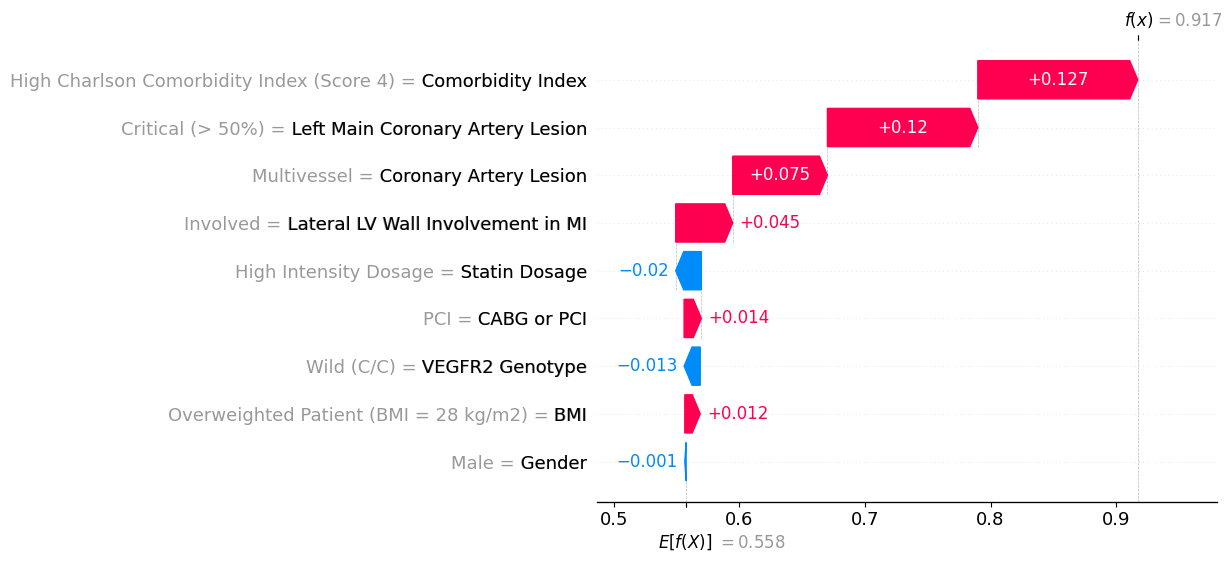

In [ ]:
make_plot(X_train_sfs,max_index ,right_values, right_feature_names,display=11,save=True,path='images/fig4.pdf')

In [ ]:
right_values = np.asarray(['Normal body weight (BMI = 24 kg/m2)','Low Charlson Comorbidity Index (Score 1)',
                           'One-Vessel','High Intensity Dosage','Male',
                           'Non-Involved','Critical (> 50%)','CABG',
                           'Wild (C/C)'
                           ])

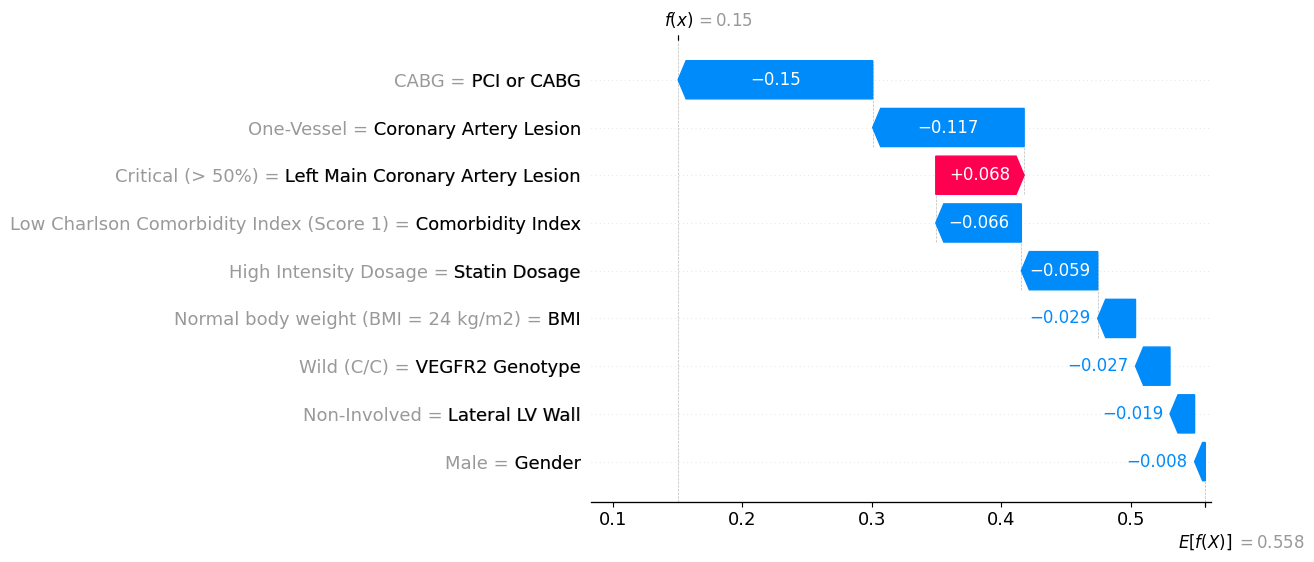

In [ ]:
make_plot(X_train_sfs,min_index,right_values, right_feature_names,display=11,save=True,path='images/fig5.pdf')

In [ ]:
right_values = np.asarray(['Overweight (BMI = 32 kg/m2)','High Charlson Comorbidity Index (Score 4)',
                           'Multivessel','Low Intensity Dosage','Male',
                           'Involved','Critical (> 50%)','PCI',
                           'Polymorphism (C/T or T/T)'
                           ])

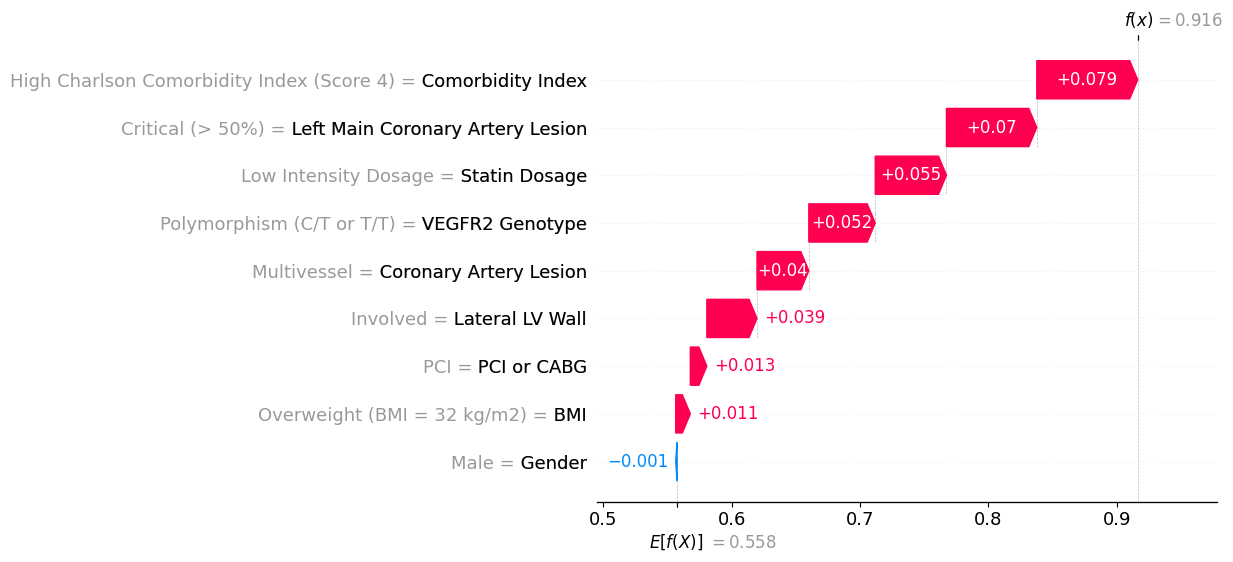

In [ ]:
make_plot(X_train_sfs,risk_indexes[-2],right_values, right_feature_names,display=11,save=True,path='images/fig4.pdf')

In [ ]:
risk_indexes[-2]

137

In [ ]:
len(y_train)

163

In [ ]:
y_train.values[risk_indexes[-5]]

1

In [ ]:
probs[risk_indexes[-2]]

0.9163260292035604

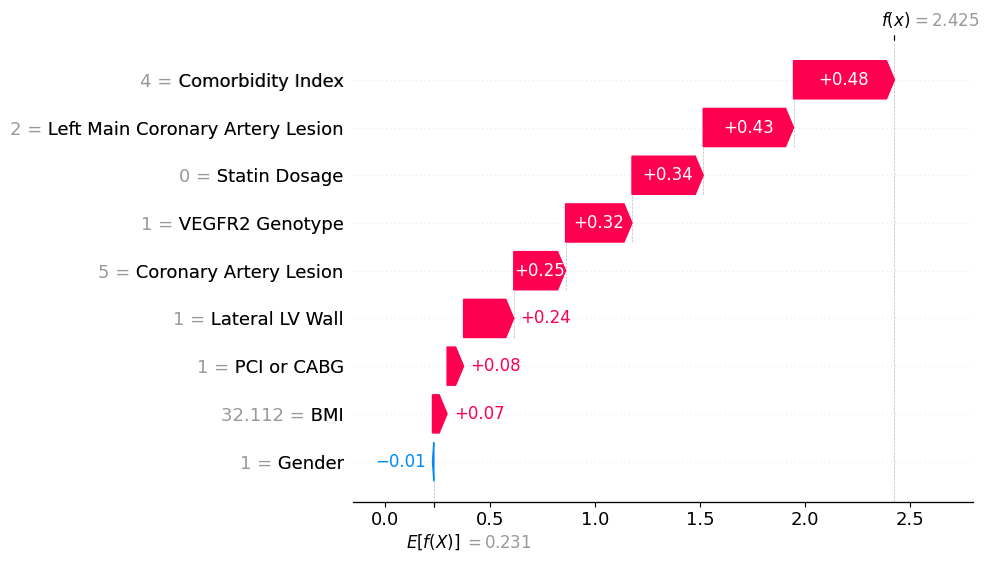

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[risk_indexes[-2]],max_display=11)

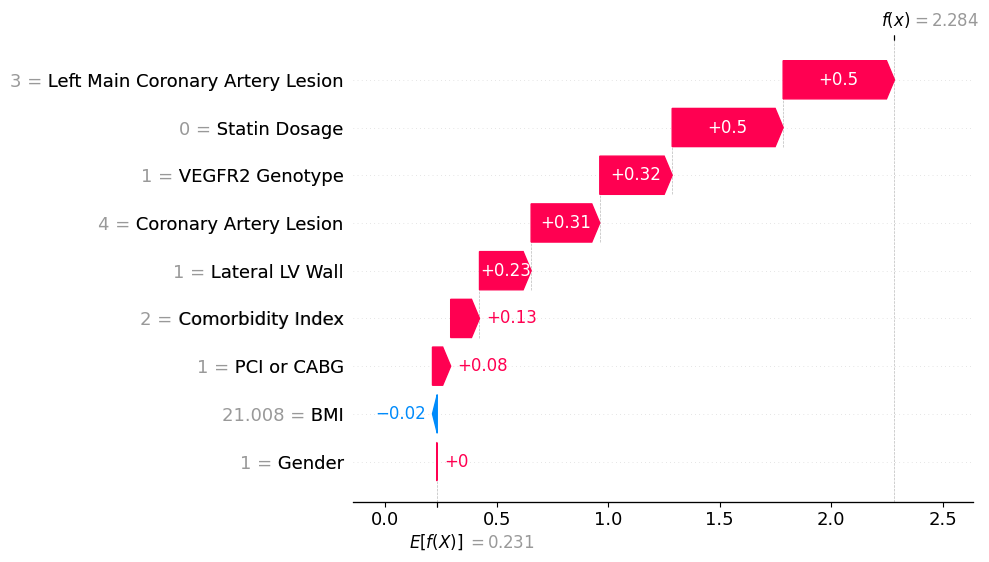

In [ ]:
shap.plots.waterfall(explainer(X_train_sfs)[risk_indexes[-5]],max_display=11)

## General

In [ ]:
res_for_graph = res.round(3).sort_values(by=['ROC_AUC','PR_AUC'],ascending=False)

In [ ]:
res = pd.DataFrame()
res['model_name'] = res_for_graph.index.values
res['ROC_AUC'] = res_for_graph['ROC_AUC'].values
res['models'] = ['Conventional','Conventional','Conventional','AutoMl Baseline','Conventional','Conventional','Conventional']

In [ ]:
fig = px.bar(res,
                   y='model_name',
                   x='ROC_AUC',
                   #title='Model Comparison by AUROC',
                  #color = 'models',
                   text='ROC_AUC',
                  labels={'table_name': 'Dataset', 'ROC_AUC': 'AUROC', 'model_name': 'Model'})
# Add ROC AUC values inside bins
fig.update_traces(marker_line_width=0.5, textposition='inside', texttemplate='%{text:.3f}',textfont=dict(color='black'))

# Remove axis and legend inscriptions
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(legend_title_text='', yaxis={'categoryorder':'total ascending'})

# Update axis labels
fig.update_layout(yaxis_title='Model Names', xaxis_title='AUROC')
# Save plot
fig.write_image("images/fig1.pdf",scale=(180 / 25.4) / (700 / 300))
# Show the plot
fig.show()

In [ ]:
from PIL import Image
# Open the image file
image = Image.open('images/newplot.png')
# Get the DPI of the image
dpi = image.info['dpi']
# Print the DPI
print(f"The DPI of the image is: {dpi}")

KeyError: 'dpi'

## Roc Auc Distributions

In [ ]:
cat_features = categorical

In [ ]:
X_train = imputed_train[sorted(imputed_train.columns)].copy()
X_test = imputed_test[sorted(imputed_train.columns)].copy()
X_train[cat_features] = X_train[cat_features].astype(int)
X_test[cat_features] = X_test[cat_features].astype(int)

In [ ]:
baseline = joblib.load('/content/drive/MyDrive/1231_ABCD/baseline_genetics_new_feature_new_target_1.pkl')
catboost = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_genetics_vegfr_new_feature_new_target_1.joblib')
catboost_selected = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_selected_genetics_vegfr_new_feature_new_target_1.joblib')
rf = joblib.load('/content/drive/MyDrive/1231_ABCD/rf_genetics_vegfr_new_feature_new_target_1.joblib')
logreg = joblib.load('/content/drive/MyDrive/1231_ABCD/logreg_genetics_vegfr_new_feature_new_target_1.joblib')
svm = joblib.load('/content/drive/MyDrive/1231_ABCD/svm_genetics_vegfr_new_feature_new_target_1.joblib')
lgbm_model = joblib.load('/content/drive/MyDrive/1231_ABCD/lgbm_genetics_new_feature_new_target_1.joblib')
catboost_2_features = joblib.load('/content/drive/MyDrive/1231_ABCD/catboost_strat_genetics_vegfr_2f_new_target_unstratified_1.joblib')

metric_dict = joblib.load( '/content/drive/MyDrive/1231_ABCD/metric_dict_genetics_vegfr_new_feature_new_target_1.zip')
scores = [element['avg_score'] for element in metric_dict.values()]
best_combination_index = np.argmax(scores) + 1
best_combination = metric_dict[best_combination_index]['feature_names']
s = list(best_combination)
s5 = ['Dose of Statins', 'Glucose', 'LV ESV', 'VGFR2']
s2 = sorted(['Dose of Statins','VGFR2'])

X_train_sfs,X_test_sfs = X_train[s].copy(), X_test[s].copy()
X_train_5,X_test_5 = X_train[s5].copy(), X_test[s5].copy()
X_train_2,X_test_2 = X_train[s2].copy(), X_test[s2].copy()

In [ ]:
def evaluate_metrics_scores(classifiers, X_test, y_test, num_bootstrap=1000, random_state=random_state):
    metrics = ['ROC_AUC']
    results = {}
    for clf_name, clf in classifiers.items():
        metric_scores = []
        for i in range(num_bootstrap):
            # Initialize random number generator
            rng = np.random.default_rng(random_state + i)
            # Bootstrap resampling
            num_samples = len(X_test)
            bootstrap_indices = rng.choice(num_samples, num_samples, replace=True)
            X_bootstrap = X_test.iloc[bootstrap_indices]
            y_bootstrap = y_test.iloc[bootstrap_indices]
            # Handle the case when only one class is present in y_bootstrap
            if len(np.unique(y_bootstrap)) == 1:
                continue
            if clf_name!='SVM':
              # Predict probabilities
              y_prob = clf.predict_proba(X_bootstrap)[:, 1]
            else:
              y_prob = clf.predict(X_bootstrap)
            roc_auc = roc_auc_score(y_bootstrap, y_prob)
            metric_scores.append(roc_auc)
        metric_scores = np.array(metric_scores)
    return metric_scores

In [ ]:
classifiers = {
    'Catboost' : catboost
}
cat = evaluate_metrics_scores(classifiers,X_test,y_test)

classifiers = {
    'Catboost after SFS' : catboost_selected
}
selected = evaluate_metrics_scores(classifiers,X_test_sfs,y_test)
classifiers = {
    'RandomForest' : rf
}
rf_ = evaluate_metrics_scores(classifiers,X_test,y_test)
classifiers = {
    'Logistic Regression' : logreg
}
logreg_ = evaluate_metrics_scores(classifiers,pd.DataFrame(X_processed_test),y_test)
classifiers = {
    'SVM' : svm
}
svm_ = evaluate_metrics_scores(classifiers,X_test,y_test)
classifiers = {
    'AutoMl Baseline' : baseline
}
automl = evaluate_metrics_scores(classifiers,X_test,y_test)
classifiers = {
    'LightGBM' : lgbm_model
}
lgbm_ = evaluate_metrics_scores(classifiers,X_test,y_test)
classifiers = {
    'Catboost with Statins + VGFR2' : catboost_2_features
}
catboost_categorical_2 = evaluate_metrics_scores(classifiers,X_test_2,y_test)

[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning] lambda_l1 is set=0.015453320562306768, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015453320562306768
[LightGBM] [Warning] bagging_fraction is set=0.8943145495197138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8943145495197138
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8966629265061623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8966629265061623
[LightGBM] [Warning] lambda_l2 is set=0.0013853351754522817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013853351754522817
[LightGBM] [Warning]

In [ ]:
distributions = {'Catboost after SFS': selected,
                 'Logistic Regression': logreg_,
                 'Catboost' : cat,
                 'AutoMl Baseline' : automl,
                 'RandomForest' : rf_,
                 'LightGBM' : lgbm_,
                 'Catboost (Statins + VEGFR2 Genotype)':catboost_categorical_2}

In [ ]:
# Create a Plotly horizontal boxplot
fig = px.box(pd.DataFrame().from_dict(distributions, orient = 'index').T,
            orientation='h')#, title='Comparison of ROC AUC Distributions for Different Models')
# Remove axis and legend inscriptions
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(legend_title_text='', yaxis={'categoryorder':'total ascending'})

# Update axis labels
fig.update_layout(yaxis_title='Model Names', xaxis_title='AUROC')
# Show the plot
fig.show()

In [ ]:
# Create a Plotly horizontal boxplot
fig = px.box(pd.DataFrame().from_dict(distributions, orient = 'index').T,
            orientation='h', title='Comparison of ROC AUC Distributions for Different Models',width=1200, height=1200)
# Remove axis and legend inscriptions
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')
fig.update_layout(legend_title_text='', yaxis={'categoryorder':'total ascending'})

# Update axis labels
fig.update_layout(yaxis_title='Model Names', xaxis_title='AUROC')
# Show the plot
fig.show()